<a href="https://colab.research.google.com/github/RK900/cs182_project/blob/main/GPT_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




## Instructions

- Change root folder to path to cwd so that imports work fine, this is also the directory where the yelp data is stored
- Skip colab cell if running locally

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
root_folder = "/content/drive/My Drive/cs182_project/"

In [ ]:
import sys

In [ ]:
sys.path.append(root_folder)

This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [ ]:
!pip install transformers

In [1]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

root_folder = "."

[nltk_data] Downloading package punkt to /home/shadaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!nvidia-smi

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [ ]:
from data_parsing import load_dataset
json_dir = os.path.join(root_folder, "yelp_review_training_dataset.jsonl")
data = load_dataset(json_dir)

In [ ]:
reviews234 = [i for i in data if i[1] == 2 or i[1] == 3 or i[1] == 4]

In [ ]:
split_idx = int(len(reviews234) * 0.8)
train, val = reviews234[:split_idx], reviews234[split_idx:]

In [ ]:
t = train[2][0].replace('\n', "").replace('\t', "")
t

In [ ]:
train[2][1]

In [ ]:
for i in train:
  assert i[1] == 2 or i[1] == 3 or i[1] == 4

In [ ]:
for i in val:
  assert i[1] == 2 or i[1] == 3 or i[1] == 4

In [ ]:
with open(os.path.join(root_folder, "yelp_review_training_dataset_234.csv"), 'w') as f:
    f.write("text\n")
    for pair in train:
        f.write("" + pair[0].replace('\n', "").replace('\t', "") + "\n")
with open(os.path.join(root_folder, "yelp_review_training_dataset_234_labels.csv"), 'w') as f:
    f.write("text\n")
    for pair in train:
        f.write(str(pair[1]) + "\n")

In [ ]:
with open(os.path.join(root_folder, "yelp_review_val_dataset_234.csv"), 'w') as f:
    f.write("text\n")
    for pair in val:
        f.write("" + pair[0].replace('\n', "").replace('\t', "") + "\n")
with open(os.path.join(root_folder, "yelp_review_val_dataset_234_labels.csv"), 'w') as f:
    f.write("text\n")
    for pair in val:
        f.write(str(pair[1]) + "\n")

In [ ]:
# # copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [2]:
# mount my Google Drive directory and access the training data located there
data_dir = os.path.join(root_folder, "yelp_review_training_dataset_234.csv")
# filename = 'yelp_review_training_dataset.csv'

# drive.mount(gdrive_dir, force_remount=True)


In [3]:
# load into a data frame
print(data_dir)
df = pd.read_csv(data_dir, error_bad_lines=False, sep='\t', header='infer', lineterminator='\n')  
print(df)

./yelp_review_training_dataset_234.csv
                                                     text
0       I'll be the first to admit that I was not exci...
1       Tracy dessert had a big name in Hong Kong and ...
2       I was really looking forward to visiting after...
3       It's a giant Best Buy with 66 registers.  I do...
4       Like walking back in time, every Saturday morn...
...                                                   ...
113987  The ambiance is sophisticated and upscale. Exa...
113988  ** 2.5 **The food is.....okay, to say the leas...
113989  This place was definitely a nice break from th...
113990  For my birthday i decided to get my industrial...
113991  I have liked this car wash for 5 years . Howev...

[113992 rows x 1 columns]


In [4]:
df.dropna(inplace=True) #remove NA values
bios = df.text.copy() #just use the main bio text in this example
bios

0         I'll be the first to admit that I was not exci...
1         Tracy dessert had a big name in Hong Kong and ...
2         I was really looking forward to visiting after...
3         It's a giant Best Buy with 66 registers.  I do...
4         Like walking back in time, every Saturday morn...
                                ...                        
113987    The ambiance is sophisticated and upscale. Exa...
113988    ** 2.5 **The food is.....okay, to say the leas...
113989    This place was definitely a nice break from th...
113990    For my birthday i decided to get my industrial...
113991    I have liked this car wash for 5 years . Howev...
Name: text, Length: 113992, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

## Can skip this cell, takes unnecessarily long

In [ ]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

In [ ]:
np.average(doc_lengths)

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [5]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [6]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [7]:
batch_size = 8

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [8]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="distilgpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [9]:
dataset = GPT2Dataset(bios[:int(len(bios))], tokenizer, max_length=128)

In [10]:
len(dataset)

113992

In [11]:
# Split into training and validation sets
train_size = int(0.9 * len(dataset))
# val_size = int(0.5 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

102,592 training samples
11,400 validation samples


In [12]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [13]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [14]:
# some parameters I cooked up that work reasonably well

epochs = 3
learning_rate = 1e-5
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [15]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [16]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [17]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [18]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  12,824. Loss: 5.982518196105957.   Elapsed: 0:00:17.
0:  bipartisan, and
, and
, and an, and an, and an, and an, and an, and an, and an, and an, and an.and a, and, and a, and a, and an, and an.and an, and.and a,.and and, and, andand, and, and,and an.and an, and.and, and.and a,and,and a.and an.and, and an.and, andan.and a, and.an.andan, andan andanand, andan, andan,andand,an,and,and,and,andan.and an.and,andandan, andan,and,and,and,and,an.an an.andan.andans, andandans,ans,andans, and, and, andan.and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  12,824. Loss: 3.6148011684417725.   Elapsed: 0:00:36.
0:  increasing the. The amount of money there is on the market; the amount of money there is on the market. and are. I, my. it and. I, my. It and. is. It and is. you, yourself. I, my, me. I I'm--there. my. I'm--there. I'ma, my--there. there. my. I'm--there. my. I'm, my. my. I'mand, my. I'm, my. The, the, thea, the the a. Thea, the, the a. Thea, the the. Thea, the thea, the an. Thea, the one. the a. The an, the an. The a. The a. the, the a. the a, the a. the a. the a the the, the a the the a the a. the a the a the a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  12,824. Loss: 3.2644834518432617.   Elapsed: 0:00:55.
0: day the (that was the time when he was in the number of the number of the number of the number of the number of the number of the number the number of the number of the number the number of the number of the number of the number of the number the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number the number of the number of the number of the and the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number of the number the number the number of the number of the number of the number the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  12,824. Loss: 4.198990345001221.   Elapsed: 0:01:13.
0:  Hang and old and old and old... that is my personal old wooden... and the other and the other good old... and the other and the other good... and the other good and the other and the other... and the other and the other good and the other good and the other good... and the other... and the other good and the other and the other... and the other and the other good... and the other good and the other good and the other good... and the other good and the other good... and the other good and the other good... and the other good and the other good... and the other good and the other... and the other good and the other good and the other good... and the other good and the other good... and the other good and and the other good and the other good... and the other good and the other good... and the other good and the other good and the other good and the other good and the other good and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  12,824. Loss: 2.744110107421875.   Elapsed: 0:01:32.
0:  foods in. Also, I really one with a lot of water in it. As a matter of fact, the other you should have no problem whatsoever getting the fresh vegetables in this place. Also, I do not sell any special goods. I am really a little bit tired at the moment. However, they take good care of me. They really make you satisfied and happy and is very nice. I really recommend it. Just about everyone that I ever talked to ever would ask me for a coupon for a meal or dessert. It is the best meal I have ever been at. I highly recommend it. I think this place is great. It's a quick place to get the food and dessert. Everything was great. And everything was cheap and cheap at that. And also, the price was great. And I always liked the service and people that were there all day was amazing. I don't mind anything. I don't mind anything. I definitely enjoyed it. I don


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  12,824. Loss: 2.4621164798736572.   Elapsed: 0:01:51.
0:  trail1 and a large washes. However, I was pleasantly surprised with these products. Overall, these were a excellent deal.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  12,824. Loss: 3.2677223682403564.   Elapsed: 0:02:08.
0: intend of the office of the deputy.
 assistant for the office of the assistant.
 clerk of the office, and the assistant for the office of the clerk.
 assistant for the office of the assistant.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  12,824. Loss: 3.325474977493286.   Elapsed: 0:02:26.
0:  surround ( ) the whole lot, and there are many people there.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  12,824. Loss: 2.434295177459717.   Elapsed: 0:02:43.
0:  reflex a mood in the streets where I live and it's an awful vibe. I mean it's not an unhealthy vibe, it's not an appropriate environment for anybody, it's not a place to staff and it's not something that is. It's an old fashioned bar and I'm glad it's been turned into an upscale hotel, not something that a mall can become. There's a bunch of people that work there, which is a shame, but it's not really a place for anybody. They don dishes, they're friendly, and they're not like the other places we've had that we can use for pizza and pizza. The main reason there isn't an ice cream stand isn because I'm a pizza guy. There are a few of them out there that's not made with ice cream. It doesn't really make a distinction to me. And that's why I food. I'm really just looking for things to have and I don't want


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  12,824. Loss: 2.8533411026000977.   Elapsed: 0:03:02.
0:  displayBarto, as well as, you see, the only thing worse than being in it is getting lost! When I was in it, I ate lunch every day, then walked to the library, and sat out, trying to be bored. It was terrible. It's so, so different! It's so, so bad! It's so great to eat here! It's actually pretty bad. It's actually cheaper! I bought a food truck and they gave my daughter a free beer for dinner! What's worse than this is, my daughters, and I, decided to eat here because I wanted to try out and compare the prices of the burger and the fries. This was the worst place in town, when I came here for lunch and was really impressed. I'm glad I had the burger but I definitely didn't get the fries. It's the best burger in the town. It's actually pretty good! The service and prices are high (which is very good),


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  12,824. Loss: 3.265381097793579.   Elapsed: 0:03:21.
0:  pastor's home. After the dinner the mother and son went shop. I was very happy with the store, even though I did not want to spend money on any of the products.  I ordered the lemon zinfandel, lemonade with the lemon.  The lemon zinfandel was very good but i think there is only one lemon zinfandel and I have not found the right one.   I ordered a red onion squash, tomato, cucumber, and cucumber salad and they took out all of the ingredients without leaving a dressing.  My boyfriend said he liked it that way.  I ordered a fresh fruit salad and a green salad.  I love them and there is nothing else in the store which does NOT taste like a lemon.  My friend took a blueberries salad and it was a little fresh but not the same.   I ordered the white raspberry, avocado, lime juice, lemonade.   The other ingredients were


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  12,824. Loss: 2.5024056434631348.   Elapsed: 0:03:40.
0:  illicit "convenient" location for a person to get a convenient breakfast and dinner at a different time. The staff is friendly and accommodating. The parking lot is a little, but the restaurants are decent (though the selection was relatively limited). The food is decent (although some of the options are a tad pricey). The only problem with the food is a small hole in the wall that could have been. However, it definitely is a clean-cut option for a place that could use some better food if they can find something good. And the patio is quite large to accommodate a large group of people. The atmosphere is clean-cut and very cozy. I highly recommend it!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  12,824. Loss: 2.9950437545776367.   Elapsed: 0:03:59.
0:  Liberation2 times after that2 times when they have been on the phone5 times after the start of their relationship and5 times after the start of their relationship2 times the new guy is looking for a girlfriend but the new guy has been asking me for so much more than what I've said here. Also when the phone rings3 times in a row, the guy who wants to get a girlfriend gets all upset. I have seen this happen before. I would say it's because that's what happens. Just call your mother and it's resolved.5 times around the same time the guy asks you for a girlfriend. Now the guy who wants a girlfriend is asking for this to be resolved. Also the guy that wants a girlfriend wants a girlfriend, doesn't talk to me, doesn't go to my office, and has asked for a girlfriend in a very strange manner because it's confusing. You will understand why if you try to work with an older guy and come out that you're really uncomfortab

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  12,824. Loss: 2.646941661834717.   Elapsed: 0:04:18.
0:  Nam1,100 miles to come with me when I had lunch at Pizza Place and it is always great! Very clean overall and excellent selection of salads, sandwiches, pasta, sandwiches, desserts, pasta, muffins, soups, salads and dessert. Very accommodating service and the wait staff are generous. I would highly recommend!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  12,824. Loss: 3.0409815311431885.   Elapsed: 0:04:36.
0: IONI remember being in a park when the sun was, so I went there with a couple of friends and got to sit with some friends. The place was so large that the people looked like they had taken care of business. The owner told me it was a nice atmosphere and I like good company. The waitress was super helpful and the food was excellent. We sat near the front desk with our friends. It was the most beautiful bar I've ever been to. Overall, this is just what I expected. They had quite a lot of beers and I liked them.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  12,824. Loss: 2.885510206222534.   Elapsed: 0:04:54.
0:  glimpseS' if you were there the day before.  But we decided to go with the cheapest price because of the great food and the good atmosphere in the house!  The food was ok though.  The fish and chips were very small compared to the other Asian food places around, and there wasn't a very good reason for the size of the fish plates to be bigger than the average sized fish in the neighbourhood.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  12,824. Loss: 2.6757168769836426.   Elapsed: 0:05:12.
0:  LaureWent home after 3 weeks of treatment with an orthopedic therapist, and a surgeon. She was very friendly & very supportive. She had a great time giving suggestions for treatment, and when she felt herself being frustrated at home she didn't feel too badly. I love how friendly she is! She also has a very nice wife and two great kids. We have two grand kids who attend, and a toddler who is. Great!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  12,824. Loss: 2.4768412113189697.   Elapsed: 0:05:30.
0: ismBuckets from the front of the shop are the right kind of burgers and we enjoyed a bit of their ramen which was outstanding. Definitely not the place I want to stay but there seems to be plenty of food everywhere.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  12,824. Loss: 3.1966135501861572.   Elapsed: 0:05:47.
0: oun
 shop I like the fresh pickles I bought. I like the crispy, sour, salty... delicious tasting ice cream. It's not the same as the old ice cream cone (it's just the same old... delicious). The only difference is that it's not an old chocolate milk ice cream cone. So if it's hot, go ahead and bring your own to taste... and it's good. The only downside is the quality of this ice cream cone, which I don't remember a taste.   I can't remember my last time in Korea, but the taste tasted like ice cream! Overall I like this ice cream cone!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  12,824. Loss: 3.2724609375.   Elapsed: 0:06:06.
0:  electionElection - The last major party has been the party of the centre-left. It has been an important centre-left party for many years and has been able to win many years with a decent electoral record. The parties are different. Some have taken on bigger costs and have had huge budgets (including the local election.) A lot of the people have lived in this city for decades with very good housing (and most of the houses are still), and the city is still mostly full of people.The election for the Centre has been held the year before. The candidates were very strong, and the voters were very passionate. Their speeches were well spoken and their policy proposals are well thought out (and well written). In the current general election, the Greens, Conservative, New Zealand-based and the Liberal Unionists have all had their opponents out.I have won one-on board with that party and have gotten three times better with tha

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  12,824. Loss: 3.489682912826538.   Elapsed: 0:06:25.
0:  crazyGrew up in the same town as I do. I live here and it doesn't really bother me that my daughter does not know what to do. The only thing I do is eat out at a nearby restaurant and have some great sandwiches from there. I usually order a sandwich from a place called Good Lace (good prices) and then get the sandwich without even going to the menu page for it's original lettuce (a) and tomato cheese and the tomato sauce. The chicken wings are so fresh and flavorful and the onions on the inside are amazing. They are also delicious and it's good to have fresh salad on hand or a quick bowl of salad before heading home. All in all, it's a great neighborhood restaurant, a must see for anyone looking for something to eat and stay in.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  12,824. Loss: 3.4544460773468018.   Elapsed: 0:06:44.
0:  bench1.5 months ago they also improved their pricing and prices. When i first opened i thought it was all hype. They were in a store in Brooklyn, NY to give off the vibe. They had a lot of quality stores. I ordered the best selection (a couple of bottles of beer) for $20, but they had no real reason to choose the smaller bottles of beer. A couple of people I spoke to said it was ok, it tasted like a bunch of old, crappy beers. They also had some bad quality beers. I was disappointed to find the staff were nice. It came with a great selection of items, a little overpriced and the service was great.  For me it was nice to see they had some good food to go. And not the biggest fish in the pan, but the good selection of items.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  12,824. Loss: 2.796494722366333.   Elapsed: 0:07:02.
0:  incorporatedDuke University's Office for Civilian and Human Resources has asked to have their students' job advertised on several online news websites. This job offer has been denied. You can read the whole thing here. The only difference in terms is that at Duke, the "employees" have the option to ask for or decline.If you are interested in this job, be sure to do the job application first. Your first question should be "What are the needs of your students?" Second, the department is asking you to "consider" your position if you would like to serve as the Deputy Coordinator of Office for Civilian and Human Resources. If you have any questions about the hiring process, please email Dr. Eben K. Johnson at drjohnson@duvasset.edu.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  12,824. Loss: 2.9996531009674072.   Elapsed: 0:07:21.
0: PeterThe place that they were at has been for a long time. We recently bought a 4 person group rental and our new friend wanted to give it a try. The only thing I did was drive over to the location and buy it 3 minutes. It was great and fun to watch. There was some good music, great food and great booths. The management made sure that we were in good shape, but did not allow us to leave. The place was very clean, and clean. I really appreciate them!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  12,824. Loss: 3.257469654083252.   Elapsed: 0:07:39.
0: uringNot a big fan of this stuff but it is good for those of us who enjoy playing a good board game.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  12,824. Loss: 2.7611794471740723.   Elapsed: 0:07:57.
0:  reproductiveThe location of this place should have been convenient since it's closed, but the staff had to take my order after I came in the door to let them know I wasn't hungry. There were definitely food options throughout the restaurant. Their chicken noodle soup is fantastic. The shrimp appetizer was very good.The beef brisket and mushrooms were ok but the chicken was a bit off the beaten path. Service was very slow. All in all, I'm so glad I chose this place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  12,824. Loss: 3.1866743564605713.   Elapsed: 0:08:15.
0:  zoneThe menu is excellent. They are always well stocked and I can't wait to get to eat them.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  12,824. Loss: 3.4654898643493652.   Elapsed: 0:08:32.
0:  commitsThere was a time when you could travel to the library with no problem. I remember finding out that the library was open when I entered. I figured I could find more than I remembered. And I did get two free libraries (for $200). The first time I walked into this building I was greeted by another staff member who said she was a teacher. As the hour passed I felt intimidated by the library and the staff who had been there were quite friendly.  At the moment I am looking forward to seeing what they have in store for me.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  12,824. Loss: 2.5206542015075684.   Elapsed: 0:08:50.
0:  irony- we need you to be my guest. I really appreciate the attention to detail and the atmosphere at our table. There were very few chairs and one person sat down as I waited and waited for the table to get full-so I had to give one star to that person.  When I reached my table we were greeted by a lady who was very nice and the seating was very clean, well lit and clean.  She was also a bit condescending.  We had a full table of other people with us. They were very pleasant about how they felt about us and how we felt about them.  She then apologized for what we had done. Overall, it was very pleasant and the tables were pretty clean, which we appreciate a little.  We were able to walk past some of the people we had talked to and the seating was quite small.  If you're looking for a nice and clean bar they've got things for you to look at.  However, there isn


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  12,824. Loss: 2.491748094558716.   Elapsed: 0:09:09.
0:  SahIn terms of food, the whole place is quite good.  The food is tasty, the staff is nice, the atmosphere is nice and clean, and it's a fun place to get your fix!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  12,824. Loss: 2.8073480129241943.   Elapsed: 0:09:27.
0:  BryanIf you want to get away from your busy commute, or try your best not to travel in groups, I suggest you try the shuttle program. Not only is there a line in the front of your hotel, but there are some very long lines in the lounge and restrooms of your hotel! It gets very noisy and crowded even if you're seated within minutes of the terminal and the bus terminal.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  12,824. Loss: 2.6364123821258545.   Elapsed: 0:09:45.
0:  spiritsFor all the great wine at this place, no one has ever been so impressed with their craftsmanship, but I know that many of them are a little over cooked by the time the bill arrives.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  12,824. Loss: 2.7057530879974365.   Elapsed: 0:10:02.
0:  seesa good food.  Was the original steak dinner for some reason.  My favorite part about this place is the fresh vegetables.  Sometimes even when I don't have vegetables... The place can go to a bit too fast and I think they've taken it to an extreme.  Sometimes they take my kids to the next table and I ask them to get a plate of steaks or veggie burgers, I have never had any of those.  The staff always seem to want to serve good food and I'm usually disappointed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  12,824. Loss: 2.569678544998169.   Elapsed: 0:10:20.
0:  hungry. We waited in line. Got a pizza... they were really friendly. Not the best, but it's fine. I did not have to ask for a second order - a third order would have been fine. We took them a few minutes to get us to the pizza, and we had a second order.  We arrived the first time and the pizza was ok, but the two times that I had to be there. The place was kind and accommodating. They had something to ask for. If you like Italian food (or you're a member of a community) then this place is the spot for you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  12,824. Loss: 2.0107932090759277.   Elapsed: 0:10:39.
0:  PTEAST! First of all there is a store just about to close on my property. The owner of a large selection of guitars has stopped by to check out the store and has a great selection of guitars. I'm not even close, but I've got a really good deal on pretty awesome stuff like the Acoustic guitar, the Acoustic guitar-tune-based guitar, the Ensemble guitars, and the Gretsch guitars. This is really going to help the sales person, because I'd go to a store and pick up something, to have them check them out, and have the owner check them out with my daughter (so I don't have to keep telling her I'm a fan of them). Also I love the music, and the music is good.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  12,824. Loss: 2.470130205154419.   Elapsed: 0:10:57.
0: üGiants. Their food is amazing, their cocktails are great. They have a few specialty cocktails that I personally love. Their baristas are super friendly and always want you to try something new.I would be remiss not to mention the place. Great bartenders for your neighborhood barista. You have a group of friendly bartenders with great service, their drinks and cocktails can go super cool. The staff is friendly and well organized. Highly recommend and stay if you're in the city!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  12,824. Loss: 1.7247519493103027.   Elapsed: 0:11:16.
0: ruceFancy but I am extremely lazy!My husband and I had a meal here, I ordered the meatballs and fries but the sauce was amazing. We ordered the shrimp fried chicken which was extremely yummy, although we had the chicken wings it tasted a bit over cooked and crumbled. The rice was amazing, as well as the onion and tomato sauce. I am super into fried chicken, so we could have got more, but the price was the same as the rice. We will order more of this in the future because of their good reviews!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  12,824. Loss: 2.590137004852295.   Elapsed: 0:11:34.
0:  derivativesThe food is very good and fresh. The service was fantastic. There was always someone watching. They made a lot of delicious chicken and I could tell the waiter had a lot of seasoning. The server was not very helpful as the chicken was spicy. It was not spicy, but more like sweet. The owner also had a big bowl of water. Definitely good food. Will try the chicken and fish again!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  12,824. Loss: 3.419381856918335.   Elapsed: 0:11:52.
0: This is another one of my favorites! I really wish there were more options to fill it and give the place a chance! The staff is super friendly and does it right!I was pleasantly surprised and satisfied with how the shop worked! It was a good little little location.The staff is all professional and the employees were really nice.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  12,824. Loss: 2.8036086559295654.   Elapsed: 0:12:10.
0:  rememberingLoved that we had a large number of different types of pizzas we enjoyed the last time we stayed at his, and we really enjoyed our stay there. We also liked that they had their lunch menu and we were able to add our own special sauces to the menu. Great staff and really enjoyed the friendly atmosphere. Overall an excellent experience, and I highly recommend going here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  12,824. Loss: 2.934593677520752.   Elapsed: 0:12:27.
0:  SourcesThe place is great, very clean, and not overly crowded at all. The place will hold a special vibe, you can sit down and drink there. I was given an appetizer with a rice salad and we ordered salad with cheese - I didn't like it. The appetizer tasted very light though, it was ok for a pizza. The rice salad was great and pretty tasty, but not enough to justify giving our two cents. Other than that the place seems good as always. The owner seemed to be super polite (he would let me know when I needed to refill it) and friendly. I did say he wanted me to give it 4 stars but I have found the server is actually nice and helpful and was willing to give me anything.  Still don't go there but should!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  12,824. Loss: 3.169341802597046.   Elapsed: 0:12:46.
0: emsBacon at La Boulange!  Their pasta was always so filling and tender!  I was a bit skeptical to come to La Boulange, but since the pizza was pretty fresh, this place was an excellent fit!  We stopped in for lunch and enjoyed the sandwiches, appetizers, and some of the sandwiches!  We will definitely be back!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  12,824. Loss: 2.0971405506134033.   Elapsed: 0:13:04.
0: tzCoupler!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  12,824. Loss: 2.1041808128356934.   Elapsed: 0:13:21.
0: maticMy favorite place in Denver and the best place in town to sit out and relax. I have had great things at this place but I have always wanted to try a steak dinner, and my first one was in Vegas when it was out on the Strip. Today I had steak dinner at the old-fashioned (and still somewhat delicious) Burger Queen restaurant at Mile High. The burgers tasted very good and tasted fresh. The waitress was super friendly, we asked her some questions and she explained the menu to us and told us our options. When we finally decided we would try this steak dinner, the waitress took our order and explained the menu. The food was always great! The place itself was fun and welcoming, the food and service was always attentive and the server seemed knowledgeable. The prices were also great!I do give the waitress a 5/10 rating for the quality and service, but that's only because it's my home and is not my regular seat. 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  12,824. Loss: 3.190793037414551.   Elapsed: 0:13:40.
0:  syndThe menu is amazing. I went out on a Saturday and had a nice, tasty Italian/Greek curry, which I was impressed with. Then there was the bar mitzvah place where you could order two things in a single order. There was a small dining room and a rooftop pool. It was cool having a place for a game that everyone seemed to enjoy. It was open 24/7. We ordered a cheese, a meatball, and cheese toast. It was served with tomato, sausage and salad with the rest of the meal on toast. It was pretty good. There is really nothing special about that place. I can only imagine the people driving there to get a drink while eating.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  12,824. Loss: 2.085552215576172.   Elapsed: 0:13:59.
0:  gamBought 2 beers for brunch here and both were fine. There was also a place in the basement that I got my brews from which is quite nice, but I can't say I'd order anything else unless they are so fancy. If there are any other great beers out there or any other great deals online I'd still put them in this category as well.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  12,824. Loss: 3.006632089614868.   Elapsed: 0:14:17.
0:  injuryThe owner was a nice guy and was patient. The food was good. The salad was pretty good, too. I also had the turkey burger, which was excellent. They offer a wide variety of toppings, including spicy and fresh.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  12,824. Loss: 2.862765312194824.   Elapsed: 0:14:34.
0: azaDedicated to The Barbershop & Barbershop. This has been my favorite barber shop in the Charlotte area. It has the most beautiful lighting, fresh colors, and authentic Italian food and barber is very reliable and reliable. The atmosphere is great, the owner, Mike, is friendly, professional, and accommodating, and the experience, is the same. I highly recommend this place, because it's always fresh, always healthy, and always tasty!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  12,824. Loss: 2.683283805847168.   Elapsed: 0:14:52.
0:  membraneA few good things to note about this location :- 1.) It's not expensive. You're generally looking for a casual or casual place to shop. You can pick it up at one of three other stores around town : the one at East and North. The other one at the other end of the street is a strip mall and the other one at the corner is another strip mall (and still in downtown).  And you can get your coffee anywhere, from Starbucks to Kwik. Both can also be very cool.  The staff is attentive and courteous. I was not quite sure if I could recommend this location to people living in the area but I figured that it would be a good spot for me. 2.)  This place is not overly crowded. Not at all crowded, except for the food and drinks.  The staff is polite, there was always a wait to get your food and drinks before the employees left. 3.)  I was happy to find a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  12,824. Loss: 2.380622148513794.   Elapsed: 0:15:12.
0: ijingI've visited a lot here. I would go to my local grocery stores and see the same thing as before but I found the food much to my disappointment. This is the first time I have had the place, so I would have to say it's alright. The food is nothing special. Its not that they haven't tried other places. Its good. The quality of the food is below average. You will see similar stuff going around. What else would you like? The prices are really competitive. Also the staff are good. We go a few times a week though as far as my health is concerned. The staff is attentive and it takes a long time to make sure your order has been ordered.The service was quite good however. They're really friendly. I have used a different machine than their other machines and have seen more staff here than I will ever see at their other locations. I understand that I will be paying a lot more for a subpar sushi piece than a quality


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  12,824. Loss: 2.748938798904419.   Elapsed: 0:15:31.
0:  castThe food is really good and I like the fried fish, but the chips are kind of thin because of the crispy fries!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  12,824. Loss: 2.438868522644043.   Elapsed: 0:15:48.
0:  purchI have ordered many books online and I have found that the books have come with errors or are defective for the purpose of my order. I have been asked to call home for repairs and replacements and all is great! The book has just not been cleaned by the manufacturer because the sales staff does not understand that I need a correct quote.  I will return in due time for another order which will take over 3 months.  I have contacted several booksellers to inquire about their books and they all tell me they do not have a repair center available either.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  12,824. Loss: 2.649343729019165.   Elapsed: 0:16:06.
0:  shouldersI am not a regular at this restaurant.   I was in there at 3:30 and they gave me a glass of wine that I ordered at 12:30.   The waiter ordered 2 glasses of champagne and I asked for the first glass to be added to my order.    He said they only want the champagne to taste good for me so I asked to add it.       I asked for more and he did not give me a glass.       I took my glasses off of the table, and was waiting again for the bartender to come back and take my glasses to me.         When she did not take my glasses to him, he said something went wrong, and I would go back.                                      


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  12,824. Loss: 2.5071310997009277.   Elapsed: 0:16:25.
0:  builtWhat I like most about this place is that it's close to the downtown campus and has a lot of seating for both kids and adults. It's a great place to sit at, especially for a party. The kids are quite loud (only a couple of kids) and it's a great place to start your evening when your kids are going.The decor is pretty, though the seating is okay. It's very old so you don't have to move the bar or go all out to play.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  12,824. Loss: 2.739187479019165.   Elapsed: 0:16:44.
0:  openlyI've had people telling me to stop buying this place.  I'm not sure why.  It isn't very pleasant.  The place is not clean or clean either.  They've tried to change the location and change the signage and signage has been a mess.  They're constantly trying to re-hangs up the sign so that it's clearly visible.  I would really recommend taking a look around here if you are in the area.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  12,824. Loss: 2.3622264862060547.   Elapsed: 0:17:02.
0:  haltedA decent restaurant from the reviews, but the owner has been working hard to make everything look good and well curated by his staff. It's a small selection, but the atmosphere is fresh and intimate (especially from the new 4/4.9), and if you like food in general, the food is worth an extra $.40.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  12,824. Loss: 3.555893898010254.   Elapsed: 0:17:19.
0:  NikRandy's Pizza is a family favorite. It's very friendly, clean, and delicious. It's not so expensive that it's worth trying out just to experience the family-owned style pizzas that run through the pizzeria.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  12,824. Loss: 2.195539951324463.   Elapsed: 0:17:37.
0:  tinI was excited to get an appointment and I thought it was a great time. The food came out very fast and was definitely my go-to restaurant.  Service also got better. The sushi was a little bit thin and I ate some asparagus and it really did taste pretty fresh. I'll be back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  12,824. Loss: 2.957745313644409.   Elapsed: 0:17:55.
0:  clinicalI was really excited to give this place a try. I went to find out what to expect here. The service here was excellent, but I wanted to give them an update on the location. The place was clean, neat, and quite the place. The server was great and I think she knew what she was getting. I ended up in the dining room, where we sat and talked. Very good!  We have been there in previous experiences.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  12,824. Loss: 2.2614285945892334.   Elapsed: 0:18:13.
0: lectionsMOST IMPORTANT TO THIS MONEYLOOKING ROOM: I've seen them out in the street (they never leave). I've seen several owners that never give you $20 back. They are very polite and professional. They also seem to have everything you need in your garage, even if you come from elsewhere!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  12,824. Loss: 2.4320170879364014.   Elapsed: 0:18:31.
0: elsI would definitely go again. A couple of things. First of all, this is a private club. We live in the condo complex; its fairly well lit. The room is small, and the space feels small and cramped. This is probably the closest place I've had to a room with a decent pool and a swimming pool. The bar is pretty good; they offer to provide specials, although that would be a bit pricey. If you are interested in this place, a little bit more space is definitely worth buying. The music was good; the band was awesome and the drinks were very good. We were not impressed with the food, which is somewhat a plus. This could be our only night since we had dinner here earlier in the week. Not bad, but it was disappointing. Overall, this place is worth the price.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  12,824. Loss: 2.6758570671081543.   Elapsed: 0:18:49.
0: labIt's a big place and everything you need is here.  But the only thing that's really disappointing is the food itself.  And it's pretty bad.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  12,824. Loss: 2.5977766513824463.   Elapsed: 0:19:07.
0:  tripleIn the past this property had a very nice view of downtown downtown.  Very little of the sidewalk or drive through downtown.  Now, for one of the many reasons, that was also a great feature.The location of the strip mall is in this small plaza along the road between the highway and the South Gate.  For a block with parking, the strip mall is about a mile or so from where I live so we only come here when a weekday is about, well, Friday.  The Strip Mall is a decent little neighborhood in downtown.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  12,824. Loss: 2.088212251663208.   Elapsed: 0:19:25.
0: 220I got an 8.5x25 and this is pretty much the max of everything I get.  This little store has a great selection of cigars, chamomile, guar and cigars.  I've had cigars with the same name for five months now, which was pretty good. I ordered my 6 pack and got a free cigar.  It comes with a 20 pack for $9.99.  The cigar has a very light amount of tobacco inside and is light with very little sugar content.  If you are trying to decide on a cigar, you probably just need a little extra puff.  This particular cigar is on my list of top 25 cigars I've ordered and is a great recommendation.The prices for 5 of them are $16/box for a box with 8 of them.  I'll probably go back to the old "5 cigars and 50 cigars" price tag that they used when they sold my house.  The reason I've been away is


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  12,824. Loss: 2.7619690895080566.   Elapsed: 0:19:44.
0:  SeeGrocery,  the place will take 5 or 6 meals with no rest.  We would recommend a quick lunch but we found there to be more than enough for a night out.The food was great, delicious and clean, but no food was fresh or fresh. A few items that were good were not as good as they should have been, but they added a good flavor to the food - they tasted fresh.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  12,824. Loss: 1.9483602046966553.   Elapsed: 0:20:02.
0: @@A fine meal, but the service is slow.  One tip: avoid ordering from the kitchen unless you have to take out the lunch boxes.  You have to take out the lunch box and make sure it's clean before you go.  Not sure if this is a good thing, or just a friendly surprise.  Other comments:- This place's great, but they charge fast, if you're a typical customer I'm not your guy, the service is slow, not my type of restaurant.  I went here with friends to grab a margarita.  I ordered a salmon salad.  I wanted a salmon salad, and instead of having to order it off of the menu there was an app, I had to order the salmon.  The salmon wasn't fresh and had a "dry" taste that made it hard to make fish.  The salmon wasn't very flavorful, it was too dry.  I didn't have a lot of fish on the salmon, so


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  12,824. Loss: 3.1456828117370605.   Elapsed: 0:20:21.
0:  hostWife and son who work at the mall and who lives at 811 East Ave NE on the south side. They have a lot of products and stuff available which I like, and the women are really helpful with their service. But the manager is uncooperative, and just rude as a manager. They told us we need to get some work done. I asked for a cleaning, and she said "we do but that's not your job. You have to do it yourself." We decided to return to the mall in a few days for a massage. I called a friend from Toronto's mall to ask if we needed a new manager in Phoenix, but she told me it would cost $5 if we didn't get a massage right away. The guy went to pick us up, but we didn't leave until he called me out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  12,824. Loss: 1.4829130172729492.   Elapsed: 0:20:40.
0: roleI'm having trouble viewing the menu because of poor taste in their fries. The fries aren't what's on tap so I'm looking for fries that are fresh and delicious.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  12,824. Loss: 2.4638001918792725.   Elapsed: 0:20:57.
0: iacThis is an excellent place to go and get a quick workout done while walking or biking. The only bad is that it isn't close to the mall so the workers are usually very small and busy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  12,824. Loss: 2.3269312381744385.   Elapsed: 0:21:15.
0:  LDI found it to be much cleaner and more convenient than my usual grocery store, a small and well organized store, which makes sense considering the fact that I used to go there frequently, even when I was on a rush. I also got lots of help from my doctor, who encouraged me to get a new one, which they did! I will be giving 5 stars if they have any better quality items on sale. If I didn't want the grocery stores I wanted in my area, then it would just be my thing. My local Walmart is a bit more pricey for a grocery store, but this is another reason to try if you've not tried it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  12,824. Loss: 1.943096399307251.   Elapsed: 0:21:33.
0:  ListenCuz it really is my first time going back here so I am gonna wait a little longer.... The staff are super nice and I get a great workout out of doing it. The employees are friendly and helpful with a ton of things we need to do. I am in the mood for some quick yoga in the summer as well!!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  12,824. Loss: 3.342797040939331.   Elapsed: 0:21:51.
0:  dyThe owner's son was very attentive and helpful when trying to explain the situation to me and then had a very good conversation with me.  It was not a great experience, as I had to ask for a "special occasion" as a waiter at the store.  I would give this place 5 stars for a good dinner with the addition of a side salad and an appetizer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  12,824. Loss: 2.7588651180267334.   Elapsed: 0:22:09.
0:  DomesticI was excited for the price point and quality of the store, especially as I am a long time owner.  Their staff are amazing and I would definitely consider visiting, especially considering the location of my condo.  The location is located a couple of doors from the main building on the south side of the store.  That doesn't take long considering there are several rooms on the second floor of the store.  The store also has a large collection of furniture, so it's definitely worth considering going there.  My only regret is that some of the photos on this review were taken at a recent vacation.  The store's price has dropped so far though.  There's no mention of the store on their website, and this is the only reason to visit.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  12,824. Loss: 2.368695020675659.   Elapsed: 0:22:28.
0:  beneficiariesIt was awesome for this event!  I went in just to grab a drink and the people behind me were so helpful in providing me with a beverage of my choosing!  I had a beer (the only drink I had was a bottle of beer!) as well as a couple of drinks from one of the tables.  I had to make sure it was a good one to get my friends to try it!  I am not a fan of Starbucks's  good old fashioned  Starbucks  coffee drinks too because of the horrible taste of the espresso/brew tea.  I ordered a drink of a glass of coffee which is more like  a Coke, but the beer was excellent and the person who came out to order a glass of milk was a bit disappointed in the fact that she asked for the milk.  She didn't seem to know she was being rude and didn't seem to be taking my order and not paying for it.  I wish I had gotten it sooner! 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  12,824. Loss: 2.700538396835327.   Elapsed: 0:22:47.
0:  TitleI've always loved the burgers and fries from this location. For a $7 burger and fries, this place makes the best burgers in town. But this is the only way to get a real good burger! You'll find one to your liking - the food is always good, friendly and your order of fries is always the same. The fries are always fresh and tasty!The fries are usually good, but when you order another burger they ask you for a different burger - which is a pretty gross. I also prefer my burgers hot and sour. The fries here are great, especially the hot ones.The cashier is friendly, helpful and takes you to the restaurant as your own guest.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  12,824. Loss: 2.906649112701416.   Elapsed: 0:23:05.
0:  μThe food is good, the service is super good, the prices are good, the atmosphere is warm and friendly. They serve the regular Korean kimchi (slightly more sweet than regular), a special pork buns and a special rice dish for dipping for the family. It's a perfect place to go on Saturday nights.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  12,824. Loss: 3.33264422416687.   Elapsed: 0:23:23.
0:  sellingGreat price and very good service. No worries about your drinks at all. The only thing that bothers me is that this place isn't cheap.  You'll get 3.50 for 1 drinks and another 5 for 10 with the $5 table. The rest of the time you'll be paying $5-$10 for a $6 drink, which has to go to pay for it all.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  12,824. Loss: 2.9006407260894775.   Elapsed: 0:23:41.
0:  migrantThis place is a big hit.  Not bad, if you don't mind some pretty big chunks of meat on your plate!  They take advantage of their location in a shopping mall.  The portions are very generous, as if you're not shopping at Walmart (I think you need to be a little more aware of these "specialty" items, they have no more of them than Subway does of the "regular size" sandwiches) that they carry.  The meatball sandwich was good, too!  The bun is small.  The burger was nice, too.  Good sized bun, I would give it a shot if I had the chance!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  12,824. Loss: 2.7725789546966553.   Elapsed: 0:23:59.
0: ivelyThe food was okay. But the drink selection was limited.  Our waiter had a dry sashimi and was pretty rude.  We would rate it higher than the other places in Phoenix.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  12,824. Loss: 2.5743799209594727.   Elapsed: 0:24:17.
0:  orderThey are a great place to watch a movie (usually 7pm or later with a projector). I go to this place almost every night and I find it nice and fresh.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  12,824. Loss: 2.8169286251068115.   Elapsed: 0:24:34.
0:  VPNWe were visiting a local restaurant in downtown Vegas and we visited this location several times a week for the past few years, for quite a few years. We really enjoyed each time since we always enjoy our food.  We usually go to the restaurant in the evening and order what we want, which I like to think will always be a good food, and it does happen on a regular basis, but that is usually fine.  I ordered a sirloin salad, which was a decent portion.  The sauce (bacon, avocado, and cucumber) tasted like a little something I'd wanted to go in order to have and we ordered the other salad.  I guess the salad itself was really good, but for the price I would have given it another shot.  The salad portion was quite large, which I think is good, but not much.  Overall, we thought it was pretty good.  The restaurant, though, was a bit too cramped, especially for our


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  12,824. Loss: 2.8396337032318115.   Elapsed: 0:24:53.
0:  explanationThis location was great for a group of 5 and was so busy we stopped by the bar and ordered the beer. The portions were good, but their beers were average. The staff was nice, and the staff was very attentive. The bar was nice and clean. We tried a couple of beers which were tasty and tasty. The drink list was very nice and pretty. Service was super friendly and attentive. Had to ask our waiter for a small beer to fill out the order, and we were not able to find another small drink to fill.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  12,824. Loss: 2.3371989727020264.   Elapsed: 0:25:12.
0:  BachThe owner is great and nice. I just like to come here to play. He has a great smile and a great attitude. If you need to do some kind of music or any kind of work for some kind of money, they have good games.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  12,824. Loss: 2.9561779499053955.   Elapsed: 0:25:29.
0:  folderWe have a small family shop that is open 24/7, but when I arrived it was still packed. I was greeted at the counter and waited over an hour for an employee to arrive. However, I did not receive any compensation or leave time.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  12,824. Loss: 2.141667366027832.   Elapsed: 0:25:47.
0:  buildingPizza was really good, I will not go back again and recommend it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  12,824. Loss: 2.707231044769287.   Elapsed: 0:26:04.
0:  BabylonI got my fill of meatballs last night after going to the local Burger King that they had been open for about 5-6 hours.  I am not sure why.  I don't know if they got them all out and it took 10 mins.  I guess they have no clue if they have the food order ready.  So a customer got a plate and a fork and it was a large box.  I took my food to the store and the owner did not do a thing or make my order and that is what is going to happen!  There was a couple of times where I was just like "why are you there!?" and I could not find the food.  So i walked inside and they were very busy and we were standing a couple of people from different restaurants waiting for our food to make its way out.  Then in the middle of all of that chaos and a bunch of people started shouting and we had to stand outside and it just became a whole


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  12,824. Loss: 2.9739181995391846.   Elapsed: 0:26:23.
0: perialBacon. Really not bad. Not too sweet or yummy. I had the beef buns and the garlic fries and the green beans. The pork belly was quite good too.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  12,824. Loss: 2.3607337474823.   Elapsed: 0:26:41.
0:  rentsHaven't really visited any of the other eateries around the house, but the food has definitely had a good time.  The service here is decent and the atmosphere is not overly loud.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  12,824. Loss: 2.4621529579162598.   Elapsed: 0:26:58.
0:  RegThe food was a lot better. Service was good but not as good as it is with the others. You have to try them while you're walking through. If you order something you can't eat, the food may not be cooked at all for the meal. We only got the chicken shawarma with tomato. We would go back if it was as good. I personally ordered the fish fry and it was good but I think the fish is too fatty and the shrimp was good. The shawarma tasted like it was cooked on a grill and tasted like it was fried in it. The shrimp was very bland and the rest of the shrimp looked like fried meat. I ordered the green chili beef and it had a very sour taste to it so it had a good amount of protein in it. We ordered the fried chicken and it was good but the green chili beef was a bit salty and the green chili beef was not that delicious. The other dishes were very good, but nothing to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  12,824. Loss: 3.340122938156128.   Elapsed: 0:27:17.
0: olasI love this salon! I have tried their "I Love Art Salon" line, but the staff are very helpful and pleasant. All my appointments are done in 2-3 days or so. The hair is very soft and nice with a great feel to the skin. The decor is beautiful, but very short!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  12,824. Loss: 3.2488815784454346.   Elapsed: 0:27:35.
0:  responsesAfter a good trip to Calgary I went back on a Monday to go check on the place. The manager and I got out of our car for about 10 mins and then walked to the lobby where all was quiet. I waited for an hour and a half before finally getting some cash, a coupon, a few rolls and some beers. Then I left for the car, headed out of town to check on the place. After about 2 or 3 mins I came back to my room and was greeted by my friend and my family. The guy at the counter was very friendly and asked if we wanted any drinks. We were given a beer and some wine, then asked if it was a $10 per bottle. The wait was about 20 minutes and he took the credit and asked if we were interested. I was very happy about the service that I received, but felt it was too much of an appointment. The manager was very kind and helpful and gave some tips to help my anxiety, which is


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  12,824. Loss: 2.5198895931243896.   Elapsed: 0:27:54.
0:  attendanceThe restaurant was very cozy and cozy and they were great for breakfast or lunch, I like their eggs Benedict and grilled cheese sandwich. Very quick service. I'll be returning as I have a bit of a craving for some more authentic fare.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  12,824. Loss: 2.3267791271209717.   Elapsed: 0:28:12.
0:  rigidI did find a great spot to grab a cupcake for myself and my wife for a wedding. The staff were attentive and we all got to enjoy an affordable cupcake. We also had great flavor and delicious flavors such as almond tea and strawberries. The strawberry and coconut cupcakes looked good, however, we did not get to try their sweet and sour varieties for ourselves. However, the strawberry cupcakes were delicious. The almond cupcake was perfect! The strawberry cupcake was also fresh and very well made. The almond cupcake was delicious, however, the strawberry cupcake lacked in flavor and the texture of the cupcake was too dense. This cupcake did not look like it would be made at all. We were not disappointed, as the flavor was delicious, and I would recommend them to friends! I would not return here again!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  12,824. Loss: 3.0139706134796143.   Elapsed: 0:28:31.
0: groFor me, it's the one and only place to get food at the market (as it happens to be in this area. But I have to admit, it was quite the party).  I had a little piece of meat (I didn't really want it) I was prepared to wait for, but I wasn't so much disappointed.  The chicken was fresh and cooked nicely, a very good addition for a dinner party of 5.  My only complaint is that there are no booths to hold the meal.  A little disappointing, I guess.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  12,824. Loss: 2.8970232009887695.   Elapsed: 0:28:49.
0:  GreI come here often and find it an enjoyable experience. The ambience is great! There is always one or two guests with lots of different faces. They always seem to be very friendly and welcoming. The decor is great - lots of nice and relaxing seating! I am very proud of this place!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  12,824. Loss: 2.1401753425598145.   Elapsed: 0:29:06.
0: uraMy friend and I went to this park about 5 weeks ago.  I was so moved by it, it really just seemed like it was just a perfect experience.  The park is definitely not overcrowded.  The kids do get their walks and they all need some playing time.  I know that some of these walkers are pretty busy, so I got a few people to play with.  The playground area is small, and you can get your own playground.  The park itself is great for all ages, but it still lacks the variety of options for all kids.  I would've loved for there to be an arcade on the walls.  My friend and I went there around 3 and it was great.  It's a really cute place, and the people are generally nice people.  It's about 40 degrees outside so you could be a little nervous about getting a snack.  For the kids, their playtime seems to be very limited, and it's really


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  12,824. Loss: 2.669599771499634.   Elapsed: 0:29:25.
0:  2020A nice and small grocery store that does everything from groceries to groceries, but not everything, I think. I had the store on my way to town for an early afternoon walk in, and I was just a little tired, so I walked back to the store. It was good. Nothing to write home about. I'll definitely be going back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  12,824. Loss: 2.78879976272583.   Elapsed: 0:29:43.
0:  chargingThe staff are very pleasant and helpful! There are 2 rooms available. There was one room that came with some drinks (I didn't use the drink so it was a little expensive), there was an extra room to shower and play in the summer with some friends. There was also a room for an extra night of dancing and drinking. They had a projector on which you could play the game while sitting in front of the TV with the lights and sound effects on. I enjoyed it and I didn't get a bad experience at the theater though. I recommend it for all the types of people. It can be a bit of a hassle to get there in the morning as the bathrooms are busy so it gets busy during the day. The theater is located close to the parking lot and is always quiet so it is easy to stay if you go early or late.The prices are reasonable and they are a good value. The theater is very quiet so the only loud people in the area are the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  12,824. Loss: 2.795131206512451.   Elapsed: 0:30:02.
0:  SarThis place is great but the food itself is not what it sounds like it could be. I've had the steak and fish curry, and both were very salty. The curry sauce was very dry. Not a big deal but you can add more garlic and chili if you feel comfortable. The fish curry is better than mine, it is spicy but not great at all. It tastes like you would be eating sushi with the sushi sauce on top of the rice. What I like about this place though is it is close to a grocery store so that would be cool if the person who was helping me when I was waiting and trying to eat here was even there to help me.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  12,824. Loss: 1.8869788646697998.   Elapsed: 0:30:21.
0:  JasI always love this place. It has everything I need but the only thing that prevents me from stopping by is its lack of a good quality gas station. I've tried a couple spots in Toronto and I have to say its the best deal I've been to.  They have a number of amazing burgers and it's a great option for quick lunchtime. This place is also one of my favorites!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  12,824. Loss: 2.881267786026001.   Elapsed: 0:30:39.
0:  permitI like the food and service. I also like that there are tables to sit at. The staff is always friendly but when they go over your order and tell you your order is incorrect it's hard to understand. I just have trouble with them getting things right. Also I was able to finish a bowl here and am a bit disappointed with the delivery. The only downside for me is that all the other reviewers were not happy with it. It seems that all the food is cooked by the server. That is ok, but nothing to be expected. I feel like it is the fault of the food court.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  12,824. Loss: 3.24290132522583.   Elapsed: 0:30:57.
0:  AdministratorI wish it was the same as the other one, not the bad type. It's a small grocery store. However, I found a new place to take my groceries into when I'm in Cleveland. You can get a free "Welcoming Delivery" at a discount. (I understand they can't charge a delivery fee as far as the food goes. I'm sure they still want delivery fees, but I'd rather have the food on my cart than trying to justify that.) I was happy to finally have the option, since I know I can get a discount (but I'd rather get home and try to pay the actual delivery fees!)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  12,824. Loss: 2.5644283294677734.   Elapsed: 0:31:15.
0:  EVENTSI have used this facility numerous times from the beginning. They have a very clean environment (you'll hear them say that in their regular business hours), well maintained equipment, good customer service and a good experience in getting home when you need it. I have never been disappointed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  12,824. Loss: 3.2045724391937256.   Elapsed: 0:31:33.
0:  MentalI went in and checked in a few times during my short stay for a new haircut.  It was a good experience for both the gentleman and his wife.  They were in a busy time as they were not out the door at the time we arrived, but they were busy in and out of the office and the hair stylist was able to bring a guy working at the salon to help.  I am very pleased and will be taking care of his hair.  The lady working with me was pleasant.  She seemed very attentive and did a wonderful job of not leaving my hair hanging as was my experience with another stylist at the time.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  12,824. Loss: 2.483588218688965.   Elapsed: 0:31:51.
0: idsSugars and other drinks from around the country.  I'll be back!  Delicious food, and excellent service.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  12,824. Loss: 2.49741268157959.   Elapsed: 0:32:09.
0: ceansWe had a great time here on our first visit to Arizona.  The food was not only tasty and fresh, but delicious.  The ambience is nice, and the tables feel comfortable.  A few tables down in the lobby are more reserved, but the food tasted good too.  They had some fantastic salad choices, which I enjoyed the most, as well as some excellent pizza.  I will return back if we are in the area, and plan to return here for another visit.  The food here was not too bad, although the service was slow at best.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  12,824. Loss: 2.3716650009155273.   Elapsed: 0:32:27.
0:  geneticallyWe went for an early dinner here. The service was great for the price but not the food.The food tasted ok. But not great.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  12,824. Loss: 2.8736326694488525.   Elapsed: 0:32:44.
0:  adviceThis place is really nice and clean. They have plenty of food and it has always been clean. I've eaten here a few times so I can tell you that. The last time we took a sample of their burgers at The Fajitas they had a little bit too much oil on the chicken meat. I am a fan and not sure they are able to handle the extra oil and so the steak came out hot and I felt like it had burned my steak. There is no warranty on this thing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  12,824. Loss: 1.7714473009109497.   Elapsed: 0:33:03.
0:  incompleteWhen I heard of the "doublespoon" I decided to try it.   I know, it sounds pretty obvious, and I'm not trying to put too much weight on it.  However, I had a couple problems with the food.First, the fries were really good.  They had a lot of fresh-cooked potatoes, carrots, carrots, some meat or mushrooms.  Not very tasty but not too greasy.  The other issue I had was that the fries were really thin on the outside, while my meat tasted great on the inside. I ended up cutting my fries short.I got a 2-1/2 pound burger (1/2 c).  It was great with chicken in a sauce, gravy, lettuce, and tomato dressing on top.  I'll be back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  12,824. Loss: 3.1130292415618896.   Elapsed: 0:33:21.
0: commentWe ordered the chicken munch with chicken and the turkey entree and it was delicious.  We were told by the lady that we had to call out at 9pm on weekdays as we were waiting for a truck.  But, she said, the truck was empty because it was closed on Friday and we could have left with lunch or dinner in the morning, but the lady told us we had to schedule an appointment at 9pm.   The sandwich had a good flavor and was light on the chicken; it was not spicy but had the typical munchy flavor of chicken with a very thin sauce.  Our server was a little hesitant but said there was no rush because the food would be ready in two days.  We could order the beef munch and the lamb wtihs with bacon to go.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  12,824. Loss: 2.560946464538574.   Elapsed: 0:33:40.
0:  pilotI purchased one of these from someone in my first review in a decade and I am very glad they have been given an upgrade because they do have a real professional owner that works under great pressure. I was really nervous as soon as I got home from work to have to wait 30 minutes to get my items and when I did, he was extremely rude with me and the whole thing was not very nice. In fact I gave it a 2 star for being extremely rude. Now it's just not the worst in Vegas.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  12,824. Loss: 1.419777512550354.   Elapsed: 0:33:58.
0: gersI was pretty excited to get my first tattoo on the skin. Being my friend's age at this point, I wanted to check out some tattoos. I wanted to learn about tattoo history in general, so I took them to the tattoo shop. I didn't know how to properly get the tattoo that I was looking for, and it was hard. However, the shop was a great, I guess, as the owner.  I decided to give the tattoo a try, not expecting much from it.  I had a bit of an attitude toward the staff, and it made sense, as the prices were reasonable.  It was a little pricey for a tattoo shop that I didn't need to go to the salon, but I can't complain because my work is done right.  The staff was super friendly!  I would probably go back there for their tattoos, though.As for the tattoos.  I have never seen anything like it before, as their prices are very high.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  12,824. Loss: 2.553363084793091.   Elapsed: 0:34:17.
0:  mutationOne of my favorites. I find all food a little bit of too much. I've had good food here over the years. They are a little hard to find and a bit of pricey, but worth the try.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  12,824. Loss: 2.5374960899353027.   Elapsed: 0:34:35.
0:  DriverI'm not very sure how they got their order.  I came to this place and ordered a large burger (no cheese) which was a huge disappointment.  They only had fries.   They only had "shrimp" and they never added the veggies to the burger and they never added the cheese for the shrimp.  The shrimp on the burger was very bland and almost like they didn't have any flavor for it.  In general they don't care about serving fish.  It's just more than that if you order one large burger.  I would have given them 5 stars if the shrimp were less then 1/2 of the size of the burger they are serving.   The fish was very salty so I couldn't decide how much would be left after the shrimp was cooked to the tiniest point to get the fish.  There were a few other items that the burger was not bad for, but were really dry.  The burgers were good and I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  12,824. Loss: 2.1122887134552.   Elapsed: 0:34:54.
0: itiI like this place but it's still too expensive. And if you have a room that you can get to, it's more expensive then a room you're going to have to pay for if you're looking for a comfortable room inside for dinner or a place to watch the hockey. It's sooo convenient...I love the small space you can get in, and the cute and cozy design of the bar. It's got the same cool vibe to it that some of the other places in the place could have.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  12,824. Loss: 2.9790775775909424.   Elapsed: 0:35:12.
0: fffThe service was awful. We had a girl working on our project and was told everything we wanted was the same. After seeing the first picture I decided to get my teeth done. The woman that was talking in the booth was very rude and unhelpful. The second time she went out on the phone and had no response on my phone or my phone calls. After the first three visits my project will have gotten better and the guy I work with can do a better job.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  12,824. Loss: 2.624408483505249.   Elapsed: 0:35:30.
0: riminationThey put their best foot forward that I would not care for them. If you think they are really trying to sell you on "health", then I would not recommend this place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  12,824. Loss: 2.95029354095459.   Elapsed: 0:35:48.
0: aqueLove coming here! I love the food! It's not too packed but it has a good feel to it! I have heard about this place several times since it opened so I figured I wouldn't stop here. The service is really nice and friendly!! I recommend trying the fried rolls and I don't think I will be returning! We had the chicken salad and the garlic fried eggplant roll for $6 and the eggplant fried pork roll was very good! I would give it 5 stars only because I have eaten here many times, it seems like everything is just in the right place!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  12,824. Loss: 3.0937013626098633.   Elapsed: 0:36:06.
0: leeYou need to know the owner, if you are not familiar with them the service and customer service is also fantastic!We just went to look for a car and we had to fill out our lease. The car came and we were there almost 5 mins before anyone came with us to get out. When we left they were like 'what did you do for your money' and asked what they expected. The guy that got our car wasn't very friendly. It was just a bunch of cashiers and I really wanted the car repaired, which is a shame as it was in fact a rental.I ordered a 4L. They showed us the window sill (that was in front of me) and gave us 2 days to have it put in. At first they didn't know what window sill they were giving us and I was like 'do you mean the one that was sitting on top? This one was sitting out there somewhere.' She said it would go in the front and I could just


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  12,824. Loss: 2.747380256652832.   Elapsed: 0:36:25.
0:  AlzheimerStopped by to grab a few drinks and a beer! Very cool little park on the banks of the river! Can't wait to walk through the streets of New York.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  12,824. Loss: 3.0472376346588135.   Elapsed: 0:36:43.
0:  checkingI am a registered nurse, so I have been writing reviews on a lot of products.  I started in on a new prescription, a laser  treatment for a small dog (pups), and I had hoped to get some results in the next month or two, but the results were extremely disappointing.  It took over a week to get my nails done.The nail care was okay but they were very overpriced.  Not to mention a lot of  little stuff like prescription drugs.  My nails looked good, but I had only received a little bit of a blackening but no actual nails for 10 days.  All in all a horrible experience for this pharmacy.  I would have given it another five stars.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  12,824. Loss: 1.8014634847640991.   Elapsed: 0:37:01.
0: nesiumI like the store because of the nice selection of items.  Their prices for items are pretty good but prices are a bit excessive for the items I like.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  12,824. Loss: 2.768716812133789.   Elapsed: 0:37:19.
0:  1957The Best Barbecue in Las Vegas. Food was fresh and tasty. Staff was great!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  12,824. Loss: 2.2997217178344727.   Elapsed: 0:37:36.
0: manshipWhat a shame!This place is in trouble.  The staff is so good but they do not understand my experience.  I was in a bar and had good food, but had a nasty experience here, just after the staff asked for a cup of coffee.  I asked why I was there in the first place but they said they had closed, the wait staff was very rude and made it seem like a quick coffee at the bar, even after all I had given them.  The coffee was not hot.  The bartender was so apologetic that she had just asked about the drink after I had given her the coffee.  That's why I took the cup of coffee and left it on the table.  Then someone else left a note behind saying I was a customer and I had done some bad things.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  12,824. Loss: 2.3354854583740234.   Elapsed: 0:37:55.
0:  understandSoureurs leurs vrai est c'est moi. L'autre entre j'ai avoir pris j'ai pour décidéré par d'une vue de plus y suivieux, et pour la nuit à tout le chef est avait fait sont pas.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  12,824. Loss: 2.491556406021118.   Elapsed: 0:38:12.
0:  passionI love this store so much. I love how they get their coupons when you are shopping around in the grocery stores like Target or Costco and I hate that they keep getting the coupons when you are not shopping. I have ordered from this store and would return as quickly as I could. I get to pick things up within 15 min from the time I get to my car.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  12,824. Loss: 2.2004544734954834.   Elapsed: 0:38:30.
0:  curvedI can't speak much more about this place.The pizza is always a treat. The food is always good. We've both ordered from here (no other choice) to go. We've been there on occasion and the food has been decent. When there's an event in town, we order the pizza and the waiter comes out and gives us the order. It's always been pretty good.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  12,824. Loss: 2.6882410049438477.   Elapsed: 0:38:48.
0:  AnTotally surprised at all how much I enjoyed their pasta and the taste of the pasta. It's definitely worth the price of the pasta. The interior is so nice, like it's in this neighbourhood, but the food and service is more like a typical Americano.

  Average training loss: 2.96
  Training epoch took: 0:38:53

Running Validation...
  Validation Loss: 2.49
  Validation took: 0:01:10

======== Epoch 2 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  12,824. Loss: 2.607267141342163.   Elapsed: 0:00:17.
0: ottiThis was a pleasant experience! After waiting for several hours I walked in and found a table.  Very large and large room was on the large side.  We ordered a couple dishes on top of the other dishes.  I ordered the onion soup, pork shoulder, chicken thigh, veggie scallop and beef beef.  The scallop was very tasty.  The onion soup was a little dry but really tasty.  The beef bone soup is great.  The pork shoulder was just too fresh for me.The beef bone soup was very flavorful.  The scallop was very good.  I would recommend this place for eating meat with chicken.  Their beef steak was quite tasty.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  12,824. Loss: 2.870283365249634.   Elapsed: 0:00:36.
0:  intakeIf you are looking for an authentic Mexican restaurant in town, visit this joint or their next door location if you are looking for another authentic Mexican place, check it out and let us know what you want to go for.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  12,824. Loss: 2.505289316177368.   Elapsed: 0:00:53.
0:  TsThe service was great. There were two guys there, but not enough people waiting.  Had a group meal with me for 3 dollars.  It was a delicious meal and the waitress was friendly.  Very tasty meal and had the seafood and the seafood were great.  Just wish they offered some options with the salad instead of the sauce, because it's a big salad.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  12,824. Loss: 2.570265293121338.   Elapsed: 0:01:11.
0:  MainJust the kindest place to get a good lunch. Staff is friendly and accommodating.  Good food, but not too big for busy times.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  12,824. Loss: 2.8130404949188232.   Elapsed: 0:01:29.
0:  temI was pleasantly surprised with the delivery experience. After we got our food order, it was taken to me by the server/bartender and the next thing I know he's standing next to us, not speaking with us and I'm asking him to leave. He said "Sorry." So he's just sitting there waiting for us to get his order. He just stared at us for a second, and didn't even reply. The customer service was even better. I really liked this place. I wish they had better service at this location when I'm on a drive to get some work done at work.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  12,824. Loss: 2.3727681636810303.   Elapsed: 0:01:47.
0:  ClickI am very disappointed with my experience with this place. We ordered dinner here on a Thursday night after an international dinner party. We sat in the waiting room for about 45 minutes, and were asked to place an order on a stand. The manager asked the manager if he could make the server sit next to us so we could sit at the table with him. He refused for an hour. He refused again on an other day. And that was in a restaurant which is not a place where the workers have the best standards of service. I am disappointed in how I had to wait 45 minutes to take my order. I would not go back if I am asked to go elsewhere. I will be sure to return to this place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  12,824. Loss: 2.7201602458953857.   Elapsed: 0:02:05.
0:  XVI'm new here and it used to be like a nail salon. We got great service, but now they use the outdated salon names and there's no sense of the new management.  But then, they always seem to get the job done and that's pretty disappointing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  12,824. Loss: 2.7526659965515137.   Elapsed: 0:02:23.
0:  dormThe food was good.  The pizza is awesome.  The toppings are great (which is something we all love).  Service is average.  A little pricey.  Our party just got drinks, food and a few extra items.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  12,824. Loss: 3.0545709133148193.   Elapsed: 0:02:41.
0:  upstreamMy first time here, I ordered it right away. I ordered the fish taco from the menu. I've got a lot of fish in it, so I had to make a couple special selections.  I got three taco's in a roll.  They all came out very nicely.  I loved that the rolls were thick and had a nice kick.  I also got my tacos.  I just wish I would get the rice and the rice was a little thinner like the real thing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  12,824. Loss: 2.7951574325561523.   Elapsed: 0:02:59.
0: الCute restaurant, very good food. Everything I had was the same except that it was slightly spicy and the chicken was slightly undercooked. It's nice to have a small restaurant and have it make new foods. Would recommend to everyone to try.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  12,824. Loss: 2.4376325607299805.   Elapsed: 0:03:16.
0: ariaWe have enjoyed our pastries here for nearly 5 years.  Our son used to love the fresh produce and fresh ingredients that we are used to.  He has become so accustomed to it, we started eating out.  It is like it is a family tradition with only one owner, but their staff is usually very courteous and friendly.  My son got a pumpkin pie for Christmas and decided to try it.  It was very tasty and delicious.  The crust was light-brown and was made perfectly.  We tried the eggplant and it tasted great.  We tried the pumpkin salad a few months ago and there was little difference.  It was perfect.  We both enjoyed the good, but the quality was way below average for our food.  We don't need more quality.  They have quality pastries at $4.00 and more.  The bakery is right by the water bridge, and you can still use the old school wooden ovens from


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  12,824. Loss: 2.8029773235321045.   Elapsed: 0:03:35.
0: PGI was staying on a Saturday night. The restaurant at the bottom of the hotel was clean and the bar/lounge was very loud. You'll find much better reviews here online.I ordered the "poutine" (a combination of sweet potato/rice and poutine with mashed potatoes). It was good but not spectacular.The poutine was good - but not amazing. There were a lot of things that I had not gotten. I ordered a cup of rice which was just a bland mixture of rice, no flavor and no water in it. My bf had the chicken poutine and the chicken dish tasted very bland. I had to order the "rice" which was mixed with rice but no flavor. They used different brands of spices but the spice used to be different which I never got before. I had to change it in the binder which I found disgusting. A couple of the dishes were even more mushy than before.The poutine took a while. I got


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  12,824. Loss: 2.808483839035034.   Elapsed: 0:03:54.
0: IllThis location is an improvement in the size of the gym. The gyms are much cleaner than others. Gym staff are good and there are lots of fun activities. Gym machines are fun for a gym player or a group of 20 to play with. There is also plenty of cardio machines and warm-up and stretching equipment to play with.  The gym is very small and can get pretty packed at times, especially during the winter (I found it easier to find the gym when the heat was in). I like that they have locker rooms. I can go to the gym and I enjoy the warm-ups and runs and the fitness classes for the guys I've never had. However, if you're tired and desperate, I would advise you to try more machines.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  12,824. Loss: 2.8315136432647705.   Elapsed: 0:04:13.
0:  automatedI've been looking for a good Korean spot for awhile now, when I'm in California.  They are good, but nothing quite comparable to T.G.I's or T.G.I's.  The owner is very friendly, I'm sure.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  12,824. Loss: 1.7741706371307373.   Elapsed: 0:04:31.
0:  hiringI work at a gas station in Concord, and while they can accommodate people with limited mobility I find that they are not very accommodating in the long run. I understand they may not have the most stringent security policy but the staff are always friendly and always seem to be following an individual's schedule.The employees are always pleasant and I've had their name checked a lot! The manager is an old school person who has never had a job anywhere else and she just seemed very nice and helpful. The service is good, however I still find it an uphill battle with the fact that they often send me a couple of free drinks or snacks with the exception of a few days when I am in the process of paying taxes to cover transportation fees.The customer service is decent. The food itself is usually pretty good; however there is often an obnoxious girl at my table who comes up to me when I'm ordering my food and re

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  12,824. Loss: 3.0887136459350586.   Elapsed: 0:04:50.
0:  tweetingGreat family-owned store (so far). Nice decor, friendly staff and fast, friendly service. Great deal with coupons & giveaways.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  12,824. Loss: 2.833491325378418.   Elapsed: 0:05:07.
0: abitI've been going to this restaurant for the last couple years and I don't really see how people are gonna do business with it. The owner/owner is awesome. He gets all of our orders right and everything is done right. They take great care in maintaining the food. The fries and burgers are excellent. I love the french fries that come with them and the fries and burgers are not overly sweet or dry. The only reason I give it 5 stars is because the food is always okay. They never go over priced to justify more of the high prices. The only reason I give it 5 stars and will keep going back to them is because the customer service is good. I would definitely go again but it won't be for a couple years.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  12,824. Loss: 2.1241354942321777.   Elapsed: 0:05:26.
0:  iiThey use to say this is the same as most Chinese and American places and it's not and it won't be. It is a bit like Starbucks,  they do not make you wait in line for the same day as the Chinese and Japanese places so it seems a bit of an awkwardness.  I love going here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  12,824. Loss: 2.7999913692474365.   Elapsed: 0:05:44.
0: clipI had a great experience with Ape-Kara at their online store.  I would give it a 5 star, but when I tried to pick one up that was already discounted at Ape-Kara I was pleasantly surprised at how good it actually was.I do recommend this store.  I did notice a difference in my order, especially when I picked up something on sale here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  12,824. Loss: 2.2700464725494385.   Elapsed: 0:06:01.
0:  FrancIf you have a nice house in Montreal or would like a stay in a hotel at 2,4, and 5th, why don't they give you a room in Montreal or a hotel near you, right on Mainland Road? Or maybe you should try and stay elsewhere in Montreal for more of a "friendly" experience. I recommend the 2 bedroom family room, but it's not quite spacious. I like the breakfast at the house that you come by that you can sit and eat for a little while. I had a friend get a bite to eat and get her back together. She was happy. And she's not alone here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  12,824. Loss: 2.217715263366699.   Elapsed: 0:06:20.
0:  listeningI've stayed at this place for at least 10 years, and was impressed with how nice the facility was. I do recommend the Pecos Chicken soup for the size. It comes with a few pieces of chicken and a few sauce on top, so you can either order a pot of soup for half the price, or you can order it without sauce, which is great! This is also a great place to grab something when you're in downtown downtown Charlotte, so you never have to worry about waiting long for your food. The store has a ton of good items. I was looking forward to going there, but when I arrived it was about 6-9PM, and my friends/family came early for dinner. The soup itself seemed delicious and was good, but the quality of the chicken was low, and we did not go in early, so the soup just wasn't worth the time we spent to get it. When you get the soup, you get your lunch, but it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  12,824. Loss: 2.413703203201294.   Elapsed: 0:06:39.
0:  EUMy family loves to go here for Christmas.  They make the most of their holiday shopping and are well-suited to the warmer months.  I visited the store yesterday afternoon, and I was pleasantly surprised that all of the items were sold out.  Although my family bought many items from here, it was no longer possible to see my kids or purchase additional items.  I was a little disappointed.  However, after we decided to stop in for the holiday, I was able to purchase a bunch of Christmas goodies and they are all good.  Unfortunately, they only had one Christmas ornament available for purchase, which was the Christmas tree, which is always sold out.  I also ordered a gift card for a purchase I was really excited about and they were very kind and explained why it might be possible to put something on but in the end, I ended up placing a second gift card rather than purchase more. I'm a little disappointed because, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  12,824. Loss: 2.823317050933838.   Elapsed: 0:06:58.
0:  incredibleI'm a fan of their food and great service. I've had a couple of different tacos, and I love the little pieces of meat that they add to the tacos. I usually like this place, but I just don't care for the variety they offer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  12,824. Loss: 2.4081485271453857.   Elapsed: 0:07:16.
0:  TYI did the same thing to my own mother's  last year as my dad and I.  The service was a hit and miss.I didn't think we'd end up having many problems with the staff but it has been really helpful.  Our  kids had a nice ride on Monday evening.I would definitely go again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  12,824. Loss: 2.1722640991210938.   Elapsed: 0:07:33.
0:  230I used the food here because it is inexpensive. I also ordered the burger and the salmon tacos which were great. I was told that their lettuce wraps are not good. The lettuce wraps are quite average, not really a good sign but nothing to write home about as they get less lettuce per sandwich. I ordered the salad on bread and the cheese. They also offered to make the salad with the lettuce wrap. Overall they had a decent meal. I would come back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  12,824. Loss: 2.315641403198242.   Elapsed: 0:07:51.
0:  TigersGreat pizza. Lots of space. You only need to get a half pizza per person!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  12,824. Loss: 1.8583592176437378.   Elapsed: 0:08:09.
0: CDIt's not bad, it has the quality and price points of any grocery store but they need to add a little more money, they are short staffed and have a lot of unorganized parking, the employees are horrible


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  12,824. Loss: 3.0171000957489014.   Elapsed: 0:08:26.
0:  unbelievableWent in the afternoon for the first time today, we walked in through the door and heard the sound of the kitchen door slamming in front of us.  The lady who was working here was super friendly and very nice.  Food was also super nice.  The only thing I liked about the place was the lack of parking.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  12,824. Loss: 2.555539608001709.   Elapsed: 0:08:44.
0: RobertNot a lot of room, but I have noticed that many other businesses have very clean bathrooms that are very clean. The cashier didn't seem to care. She just shrugged the cashier off, and then pointed to another one. The cashier was also a little rude to my friend when we left the store with her shoes and socks.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  12,824. Loss: 2.498025894165039.   Elapsed: 0:09:02.
0:  ContactMy new york house is in great shape with new apartments.  The new apartments, with lots of new amenities, are a huge step up from old apartments.I've lived here three times for five years.  I'm never seen here for much.  They've changed their tenants a lot.  The new apartments have very little new seating.  There are really little restaurants around, just small restaurants that get served by very few people.  They also tend to have a few parking spots available.  My only complaint is that there is one parking lot. I think it might be a little overzealous, but it is definitely good if you're not a fan of the "big guy" attitude.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  12,824. Loss: 2.67366623878479.   Elapsed: 0:09:20.
0:  fountainLove this place! I have not been here on a Sunday since I bought my car a few years ago. I always get a fresh and crisp sandwich that has a little bit of crunch and crunchy inside. The food is great! They have plenty of veggie soups and salad mixes too! I love how you can order something on the go, or bring your own! Highly recommend this place!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  12,824. Loss: 2.643313407897949.   Elapsed: 0:09:38.
0:  clashGreat food for the price!! Great price for all your drinks. Had a special dinner party. The restaurant and atmosphere was nice! Great ambiance.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  12,824. Loss: 2.9288008213043213.   Elapsed: 0:09:56.
0:  commodWe live in the Phoenix area and I loved this place. The decor is a bit of a hit or miss. But overall it was fun being there. It was quite crowded and it's not difficult to find a sit down place and watch the game in the living room. But the seating is quite solid. They have a little arcade and they have seating inside which is quite nice. I definitely had a good experience. They have TVs which you can play at anytime, although they do have a couple TVs upstairs which they still don't have with us. I have a small TV in a chair by the wall. But I think that it's worth it to have something available if you want to watch some sports and not have to go to the theater to watch games. Our server was nice but the lady who helped us was a little annoying. We ended up finding a chair and the girl that helped us was in a big sweat pants.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  12,824. Loss: 2.452415704727173.   Elapsed: 0:10:15.
0:  algorithmThey did a fantastic job, we had a great time. But, our service wasn't great either! We couldn't find a replacement for the manager, it was hard to get her to do our tasks, we did have her answer some of our questions (we had a bad experience with the receptionist) and no one spoke Spanish whatsoever.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  12,824. Loss: 2.769890308380127.   Elapsed: 0:10:33.
0:  accurateGreat service. Will be back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  12,824. Loss: 2.690669059753418.   Elapsed: 0:10:50.
0: adoIt's a bit off the beaten path but the food is alright. The ribs are very good. They offer fresh fruits in the sauce. I went last week for some chicken frys and the ribs were cooked very well. This place is a lot better if you live in the area. My friend ordered the frys and liked it better. The only downside would be the service. The frys that he ordered were not cooked as well as the ones that I had. Overall, this place is a little expensive for my money but the food is great and everyone can get their share of it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  12,824. Loss: 2.5310702323913574.   Elapsed: 0:11:08.
0:  regulateGreat food, I'll definately go back. This restaurant was okay. It was clean, the staff were very friendly (did not see too many of them) and the food was reasonably priced. I would definitely go back for the food and drinks!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  12,824. Loss: 2.49208664894104.   Elapsed: 0:11:26.
0: ewayA delicious French brunch bar, we had the choice to try their menu or just to see if there was any speciality or a dessert. We ordered the red soggy pancakes. They were tasty and the maple syrup with the vanilla whipped cream was perfect. The pancakes were very crisp and fluffy and delicious! Their French toast was also very good and filling! Service was friendly and friendly


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  12,824. Loss: 2.2265899181365967.   Elapsed: 0:11:44.
0: itteeI have eaten here for the past four years and this place definitely deserves an update.  The owner has moved from the old space to the new one at one of the tables which is what I loved.  Everything else in the store was just ok.  It was very busy when you went and one employee at the front desk actually tried to help her out.  Overall, it was great service, I would recommend them to anyone who is looking for something casual or the kind of place to go.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  12,824. Loss: 2.506906747817993.   Elapsed: 0:12:02.
0:  JackieNice decor and nice people that serve our food. It's kinda like a mall. The only thing that can mess this place up is one huge coffee table that needs work. Our food was decent... not at all good... no sauce. So I won't try. We had a big burger and grilled cheese.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  12,824. Loss: 3.038041114807129.   Elapsed: 0:12:19.
0: HeOne of the funniest spots in the world!  The girls at the front desk are so friendly and all the staff just love taking orders.  It's all about getting a quick bite to eat and to get some cheap fresh fruit and veggies.  They are also open 24/7 which means your food gets delivered very quickly.We were at this location with two of our family, and we wanted some food that was both fresh and delicious.  We ordered their chicken and pork sandwich and it was perfect.  The fries were quite tasty, and really good!  The chicken was cooked very well, and the pork sandwich was good, but didn't take very long.  We also ordered a turkey sandwich, which is pretty good, but the turkey wasn't the best in the world.  I just don't think it's worth the money to order it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  12,824. Loss: 2.476937770843506.   Elapsed: 0:12:38.
0:  wiredWe come here for breakfast every weekday in the morning. We love to come here whenever we're on the move and try on things, they're always great to watch as we're doing research before bed. We love this place as we sit for breakfast all the time!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  12,824. Loss: 2.6232168674468994.   Elapsed: 0:12:56.
0:  frequWe had lunch here recently, and we had to return to Vegas to get a pizza, which would be a good thing. The pizzas are not bad, but don't expect it to be good if you're not in the mood for a quick lunch. I don't eat Italian or any other form of pizza - this is a place that serves it perfectly. This was not the most "fresh" or fresh food we've had at all. There's the cheese, there are basil and cilantro, all things that taste delicious. The pizzas were a little old, but they were decent. Overall the service was good, but they left a bad taste in my mouth.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  12,824. Loss: 2.514528274536133.   Elapsed: 0:13:15.
0:  viewsI had a great visit here today and it was a great experience.  I wish they could have gotten the name of the restaurant out and added it to the list of establishments we would be using in our tour, but if that's the case, I'd recommend using them on your trip.  They've got a new menu on the menu and it was beautiful and the prices were reasonable.  This place is all the way over the top, but the staff was kind, kind and friendly.  My friends and I were impressed and would go back.  The price was right and the service was great!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  12,824. Loss: 2.8964879512786865.   Elapsed: 0:13:33.
0:  StrategyI ordered the Chicken Steak and the Steak Burger. Both were delicious and were fresh. I'm sure it will be very busy.I came with a group of 6 for dinner and one friend was able to pick up two steak and they're so tender I asked the server to change her menu. They added the steak to the other steak and they are perfectly cooked. I will try it again for lunch to see if it has any flavours on it.The chicken sandwich was delicious. I also got an option for a glass of water, I wanted it to taste like a glass of water as well. The chicken was so tender and crisp! We will be back!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  12,824. Loss: 1.96071457862854.   Elapsed: 0:13:51.
0:  radioThis was a great experience! First, they took time to explain and then proceeded to describe their customer service skills and then had a thorough and entertaining conversation with our employees. My wife and I were delighted to see there was a very friendly, professional group of business leaders who had a very friendly and understanding discussion. She recommended that we visit the local Whole Foods and she was very helpful and helpful. I would highly recommend this place!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  12,824. Loss: 2.550313711166382.   Elapsed: 0:14:09.
0: oultWe ordered a large veggie salad for our birthday. It is a bit pricey and the portions were small.The staff was very attentive. The salad was served very quickly and the veggies were perfectly cooked for me. I also found it a bit too hot for my liking. The price was pretty fair since they just cut the lettuce, some of which are just not as good as they would like them to be. I will return!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  12,824. Loss: 2.483297824859619.   Elapsed: 0:14:27.
0:  ReinI'm not a big fan of the pizza here. I have been here twice now. First time, I was at a party and got my pizza there. I got it cold because I got the pizza wrong and didn't put the toppings right. I'm not a huge fan of the freshness or the way that it cooks, either and it is not good for you. The second time I ordered my pizza, the pizza was not hot at all. There was no way to make it hot enough. The other time I came in and ordered my pizza again, it had just barely hot. They asked me to bring my pizza to where it shouldn't have been to make it hot. After I ordered my pizza, I don't feel like I've ever had a good pizza here and I feel like we should put that on the menu as well. The food here is very good and it's the best I've had so far. I'll be back!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  12,824. Loss: 1.454933524131775.   Elapsed: 0:14:46.
0:  procI visited the office on Thursday to look at some paperwork and a recommendation on what I wanted in terms of my home and business needs. I called the office several times, one time for another person (who called as soon as possible), and it was clear to me that this company wouldn't be willing to assist me on that basis. This new location in a mall is better, but I still need the office. It's so convenient for me to get around to checking the internet, but there is no one there on Thursday and I'm not sure what they would do with me. There was none in sight. The only people I saw were a coworker, my cousin and a friend working at my business. I told them I needed something I wanted, that they were probably going to do an office appointment on Thursday morning and they wouldn't be available. A week later, they finally appeared. I told them I was in for a cleaning and they took over an hour to do it and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  12,824. Loss: 2.3005409240722656.   Elapsed: 0:15:05.
0:  abusesThe food is amazing!! The waiters and waitresses were fantastic and the staff was super friendly. If you like to wait for food in a plaza in the park, and you are in the mood to take your kids here (and maybe some food they give away at the table), then this is a great place to get your attention!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  12,824. Loss: 2.4689433574676514.   Elapsed: 0:15:23.
0:  waI have a pretty low tolerance for being "dishonest" in my reviews. But my boyfriend, who is very picky, never takes too much time (and sometimes it's okay) to read my reviews before taking his eyes off the screen. We're in the neighborhood, in a very large group, and I haven't found a bad review I like before. I usually take the time to consider how much he might care about my opinion, or if he actually cares.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  12,824. Loss: 3.007723808288574.   Elapsed: 0:15:41.
0: lectedI love this place! I come in for a breakfast or lunch a lot, and usually get the same delicious breakfast with great ingredients. I have tried the fried eggplant and the salad but this was the first time I was happy with the food.  The service was really good, but the food was just not good enough to last much longer. My mom always had the veggie pancake which was great. The lady who helped me make my sandwich tasted like she was trying to put some chicken on top, and was giving a bad rating. I would definitely go back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  12,824. Loss: 2.937142848968506.   Elapsed: 0:16:00.
0:  templeThe service was very good. The place is not very spacious yet but it can be fun.  You can usually find seating in the back room for a long wait.  I tried their chunky poutine, it was very thick.  I also tried their fish roll, but they were way over cooked.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  12,824. Loss: 2.940377950668335.   Elapsed: 0:16:17.
0:  lodI got a lot of compliments on my trip and would definitely come back again. It's actually a nice little strip mall in the middle of a strip mall and was quite friendly. Prices were not too high. I had a large plate and two glasses which I thought were good but nothing spectacular but nice. It's a decent little strip mall, not anything too extravagant, but not too fancy. It has a nice strip atmosphere, and has plenty of seating too. The people in line were pleasant. They knew where to go. As the day went on, I noticed that I was staying in my room in a place close to the elevator so I decided to take a break in and to have a drink. The restaurant was located in the same building as I was at. The restaurant was located in the same hotel. This is nice for the environment of walking in. The food was good. The portions were huge. Overall, I got everything the average place would, and it was delicious.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  12,824. Loss: 2.9979779720306396.   Elapsed: 0:16:36.
0:  RioI stopped by this place on a whim and asked a few questions.  I liked the fact that they have an extensive selection of food products and drinks.   The staff was friendly and helpful and was really helpful in getting me what I needed for a birthday.  The decor was a bit old school and I didn't think the place would last as long.   The place is located in the shopping plaza at the entrance to the Old Post Office shopping center.     My first time coming, it was pretty empty.    We walked in and were greeted by several other employees in the kitchen that were friendly and knowledgeable.  I enjoyed the food and had no complaints.    They have the same standard drinks available, and the prices are reasonable.   The only reason I gave 5 stars is that my drink selections were not the best (I don't normally go to their beer/wine lines or their food selection).   My only complaint is that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  12,824. Loss: 3.0792155265808105.   Elapsed: 0:16:55.
0:  PenceThere are several things that are great about this place, but the only reason this place was so great was because of the "Cocktails". This place had over 300 bottles of cork I got when I walked in for a drink (for the money).  At one point, you'd hear the "Gooey" and the "Good" and I would hear the "Aww, you have too much cork."  I got the "Noodle" and they had it on a stick.  All the other drinks I'd received at this place weren't made as advertised and the cork was just so sweet and flavorful.  If you want a great, authentic cork, just make sure you check with the staff to make sure you can actually make it.  If you want a "cocktail style" cork that is just the way it is supposed to be, get something authentic to match the flavor.  Otherwise, if you want something that is


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  12,824. Loss: 2.6297600269317627.   Elapsed: 0:17:15.
0:  StevenI love what I found here.  I have tried many many things but this one I am so happy I discovered.  I love the "super hot & fresh" sandwich, it will come off like a nice summer evening for lunch and the sandwiches are tender and flavorful.  The store has everything from breakfast/burger/fish/beef to sandwiches like grilled eggs, toast, etc.  They have all types of sauces/straw breads and juices to spice things up.  My favorite is the "super crispy" sandwich.The place is clean, modern, modern, modern looking, spacious and well stocked with everything.  The only thing that bothers me is that it is an average place for lunch, but it's got a decent menu for anything.  I don't know why I did not review this place because it could be the best in Vegas, but I'll stick to the standard of "good" food, but this is the kind of place that I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  12,824. Loss: 2.787095546722412.   Elapsed: 0:17:34.
0:  discourseI don't know that much about the company, but what I did find was some very nice employees there, and the atmosphere was super friendly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  12,824. Loss: 2.345034599304199.   Elapsed: 0:17:51.
0:  accessoryI was a long time customer and have tried all the different stores and always get my order right. I do recommend this store for all the customers looking for a fast delivery solution.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  12,824. Loss: 2.5886940956115723.   Elapsed: 0:18:09.
0: ulSo far our order has been fantastic! There is something about the food, the atmosphere, it's a little bit awkward for the time of day, but for a late night brunch it's perfect! If you're looking for brunch in Charlotte, don't miss it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  12,824. Loss: 2.1940884590148926.   Elapsed: 0:18:26.
0:  slidingThe staff here is not very helpful. There are some customers working there but they are not very helpful. They don't seem to think twice about coming to check on a card. This location is also pretty good for business and cheap prices.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  12,824. Loss: 2.4109296798706055.   Elapsed: 0:18:44.
0:  DellI have been looking for a place where I can go to watch a boxing match and be told "here is the best place, you should go to another gym because they have good TVs you can watch boxing for free".I went to this gym for a couple of weeks, and found it quite difficult to find a match that I wanted to see, so I went to the old gym.  There are many boxing classes and they are well managed.  The quality of the equipment is amazing.  They have multiple TVs and a cardio room, so there is no "free" seating.  They have a good variety of supplements and you can watch a lot of great cardio.  Their equipment is a little bit too much for me to feel comfortable with, so I'm not sure if the equipment is better suited to my own body.  The only one in this gym is the main cardio room that is not very busy and is a bit on the smaller side compared to many other classes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  12,824. Loss: 2.012603759765625.   Elapsed: 0:19:03.
0: iusGreat for an awesome dinner! The menu is quite decent, especially the food and pricing. Prices are a little on the high side considering the average $23 dinner I've had over the years and there's always going to be a price increase as the food changes over the years.  The food is good, and it is tasty.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  12,824. Loss: 1.5444650650024414.   Elapsed: 0:19:21.
0: sidedOne of the few restaurants in the area that I went there for a quick lunch and a quick dinner for the entire family.  I went for a quick lunch and dinner for the family.  It was one of the few places in town that I actually got a buffet dinner and I found the prices reasonable.  Food is not the same as other places that I love to go to.  The restaurant is on the lower end of the spectrum for prices, but they have a lot of food for less.  The staff is extremely friendly and everyone was quite excited about the food at the other restaurant.  Service was good.  The menu selection is a lot bigger than other places, but I believe the menu has lots to offer for people looking for what they need.  The service was quite efficient.  I would expect more than 2 people in a room for lunch.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  12,824. Loss: 2.294632911682129.   Elapsed: 0:19:39.
0:  WPI like this location very much for the fact it has a decent location. The only major thing I like that is it has not been over-used but still the staff is helpful. The only major thing I liked that is the price point. The food is great. It's only good because of it and the staff are good. Definitely not the biggest, but it's ok.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  12,824. Loss: 2.947948455810547.   Elapsed: 0:19:57.
0:  exertI'm not sure why I think this is so important.  Well-known Chinese restaurants, you have to get one (or do whatever), but nothing beats a meal in Las Vegas or China.  The food and service was excellent.  All of the dishes were made in the very best shape, cooked well and served very quickly.  I will be recommending this to friends and family.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  12,824. Loss: 2.90075945854187.   Elapsed: 0:20:15.
0: inianThis place has a little bit of everything.  There are lots of small places to try this time.  It's not the biggest of places, but they do have plenty to choose from.  The meat is just alright, but the taste is just what they were looking for.  It was probably the best burger ever and I have to say, it's not bad, just plain ol' meat.  It's also very good, as it was served with a side of chicken which I had to ask to get.  The place is so tiny and just the size I wanted to be happy for a small joint, that I wouldn't complain to anyone.  I had the smoked brisket and it was a good meal!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  12,824. Loss: 2.4277424812316895.   Elapsed: 0:20:34.
0:  electricityGreat place! Great for the cheap and their chicken. The staff are friendly and accommodating and can make you feel at home. We will definitely return.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  12,824. Loss: 3.119473934173584.   Elapsed: 0:20:51.
0:  AviationI have been going to this store ever since moving out of Cleveland for a living. It's been my favorite spot I've been to in the area. They do have a few good sandwiches, some of which will turn you off of the gluten free options. A bit pricey for one item, but worth a go. The price is fair for what they have out of the box and can really help you find what you're looking for. A few of the items I've tried have been really amazing. I've seen them bake a good variety of food, and their staff is very knowledgeable and friendly. They carry something for everyone and they always have enough bread to carry.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  12,824. Loss: 2.4461557865142822.   Elapsed: 0:21:10.
0:  encodingGood food but service was slow and very slow. I was told to order the appetizer and to put the food in plastic container while in the restaurant. Once in the restaurant (3 hours prior to my order) the waiter tried to ask if I had a glass of wine, but I was told no, and ordered it to be taken out, he did not want to touch my wine and I could not open it. If I asked for a glass of wine the waiter took it. He said I had to ask for a drink which I did not see, as I was sitting in the bathroom. I had no choice. He then took my drink. I waited. I asked for a glass of wine and he said I did. He said no, because it was out of my cup, which I thought might be to make me feel better. Then to take the next thing out. The food was good enough to take my friend to visit him and get to see his favorite chef,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  12,824. Loss: 2.523491382598877.   Elapsed: 0:21:29.
0: fitThe place isn't that bad and they have really good stuff there.   If you have been paying attention you will find you get what you pay for.  I have also been to one of the more interesting shops there.  I usually order the chicken and veggie dishes and have made it my standard meal for this place.   The place isn't that bad and they have really good stuff there, but if you want an item that tastes fresh it's not going to be great for you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  12,824. Loss: 2.2641818523406982.   Elapsed: 0:21:47.
0:  wifeI had gone here a year ago and enjoyed my stay a couple nights. There were some big issues, the only ones I noticed were that the bed, kitchenette and chairs were so dirty. I had a really bad day while I was there. I didn't want to get to this bed and kitchenette as I was having dinner there. The guy who worked the counter next to the bed and kitchenette was just really friendly and attentive to her requests. The table in the back that I had to check in with him was a little dirty so I left the room with a dirty table. The only reason I was not a big fan of this was the way it is now. I'm glad that the people here are so welcoming and welcoming in the morning! If you are visiting from out of town or coming from out of state there is really nothing you can do to avoid the dirty chairs and dirty floors as a hotel stay.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  12,824. Loss: 2.5270445346832275.   Elapsed: 0:22:06.
0: ileyI'm a huge fan of this place and it's not a super expensive place to go, but it is still a bit pricey. It's not all bad and the portions are pretty good. The service was very friendly and the food is definitely good. I'd go back, but if I have any more questions or anything like that I don't bother going to this place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  12,824. Loss: 2.2834227085113525.   Elapsed: 0:22:24.
0: stageWent this week for a birthday party.  Ordered the "Ebola" and some pizza with my friend.  The pizza tasted very good, but nothing particularly unique.  I'd return.  I thought it was one of the better sandwiches in the area.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  12,824. Loss: 3.266021490097046.   Elapsed: 0:22:42.
0: hatI like all the food here, though it's not the greatest. The service on Sundays is good.  The portions are not great for this location as well. I went to try the fried chicken sandwich and I have to say that it was ok.  No cheese at all, maybe it was like a little crunch that was added in as well.  I guess that is just how it's called.Overall, I was very pleased with the food.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  12,824. Loss: 2.649460792541504.   Elapsed: 0:23:00.
0: RichBeen wanting to like this place ever since I saw it for the first time.  The food was always great and they have specials with different appetizers as well.  The owner, Steve,  was extremely accommodating in the hours of day and nights we were in.  Every time we were there, his wife had the fried tofu sandwich which was perfect with the hot sauce that went with it.  It was definitely the best. I will definitely be back.  They have a lot of choices in food and service to suit all of you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  12,824. Loss: 2.7917582988739014.   Elapsed: 0:23:18.
0: �Had a wonderful weekend with my wife, son, sister and great mom who we just met.The service was good, it was nice to know the people working there had a positive attitude.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  12,824. Loss: 2.430992841720581.   Elapsed: 0:23:35.
0:  pretendingI don't think it's worth $4 for an authentic French style dinner. Not worth the price. It's overpriced compared to the rest of the restaurant, but that's fine!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  12,824. Loss: 2.2663071155548096.   Elapsed: 0:23:53.
0:  PCBI like to order from them.  They were not helpful when it came to any part of the shipment so i decided to give them another chance, their delivery was much quicker than most places on the east coast so they were happy.  The store is just a few steps from where i work.  They were helpful in getting me what i wanted when I needed it.I have not ordered anything from them yet.  Some items are only $50 in my case and some are higher.  I would have given them 5 stars but the customer service seems to be lacking at most places.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  12,824. Loss: 2.163552761077881.   Elapsed: 0:24:11.
0:  retrospectThis is the only restaurant I've ever been to that doesn't take reservations. It's a really nice little space with a great service. Prices are fair - about $1 each with free breakfast, which is really great. The only downside is that they charge you if you have a credit card for the restaurant and the food isn't on paper as a separate account. But I'm not a customer - they do have a free voucher option which I'll get on the website - so just be prepared for that!The only thing that is a little weird about this place is the menu. They don't have anything special on the menu - it's just on paper. I don't know if I would call it a restaurant or a restaurant but in that case this is definitely not my type of restaurant. Overall, I would not go back! But the price was really good, nothing wrong with them.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  12,824. Loss: 2.1984221935272217.   Elapsed: 0:24:30.
0:  plainGreat location, a great place to stop for dinner.  Friendly staff, a small, friendly place to sit and watch some basketball.  Not many other places have wings like this.  The fried potatoes are great.  Would go again.  Wings were good.  Would definitely recommend.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  12,824. Loss: 2.5604894161224365.   Elapsed: 0:24:48.
0:  disclosedA great pizza place.  They always have a selection of delicious toppings and even if I'm not ordering something I will return and try the pizza again.  They also serve some of the worst pizza ever made.  I ordered a large salad and was told I was paying $6/per person.   I didn't expect much when I called up but I guess the customers would prefer them just because they like their pizza.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  12,824. Loss: 2.8192481994628906.   Elapsed: 0:25:06.
0:  beverageMy husband and I had been going to the mall in the last couple months for our wedding anniversary to find some awesome vintage stores that would open up next door. We had a great time and were satisfied to have had an opportunity to try and find a good little store that offered the sort of luxury goods and clothing we were looking for. They gave us one of the better deals in Charlotte and I am very happy with that.The store is located near the University Hospital. It's really big! They have a huge section of high end clothing, accessories, jewelry and accessories that they've got on sale. The store is packed with unique vintage items from around the world, and a great variety of vintage and brand new styles. I was lucky enough to have the opportunity to try one of the new products.I came out here to buy gifts, and it took about 10 minutes before we realized just how much time I could spend shopping her

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  12,824. Loss: 2.5664010047912598.   Elapsed: 0:25:25.
0:  ("Great food!) and they don't run out of the sweet potatoes before 10am. They've been getting their fries and fries now for 2 weeks!! I'm still going back because they're so good!!!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  12,824. Loss: 2.7480411529541016.   Elapsed: 0:25:42.
0:  foundingThe best thing I can say is that if you are in the area and want to have lunch in the mall at night, this is the place. The food is pretty good, and the prices are fair for what you get. My friends and I also ordered the breakfast plate, which is a solid combo of rice with a side of hot chocolate toasted coconut. My friend and I each got a side of eggs Benedict and a side of toast, which was also good as was the order of one side, but what really impressed me about it was that everything was on the menu, and on the menu seemed to reflect everything. All the other options were just pretty mediocre. The prices, though, are a bit high given how low they are. I have to say it's a solid combo of the rice and breakfast plate, which is good. They seem to have changed their menu a bit but overall, it's a good thing for the local area.The only downside is the lunch price


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  12,824. Loss: 2.6609959602355957.   Elapsed: 0:26:01.
0:  filesystemI'm in the neighborhood, which is nice to see.  This is my first visit since returning from the US, so my initial assessment is that the service, food, and ambiance was satisfactory.  I ordered a turkey sandwich on the same day as my visit and was pleasantly surprised that the sandwich was tender and tasty.  For my second visit, I ordered a salad on the same day as my visit but I was pleasantly surprised with the sandwich and had a salad ready for my second visit.  They also provided a "delicious salad" that I received very promptly.  The menu is small, but the service is pretty good.  I ordered a sandwich from there as well, which was tasty, although the sandwich still took too long.  I would definitely come back again for a salad on the same day as my return.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  12,824. Loss: 2.226336717605591.   Elapsed: 0:26:20.
0:  normalGreat service and fast when it's out of the way. I tried the chicken chow mein. Tasted good, I'd recommend.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  12,824. Loss: 2.5737481117248535.   Elapsed: 0:26:38.
0:  MartialA small selection of different fruit, a lot of good wine and a lot of cheap food. For example: Dried fruit, green beans, bananas, oranges and cranberries. If you're looking for a cheap and quick snack, pick up the $25 Fruit Salad.  You might as well order it as the $20 Chicken Salad.  I found that the lettuce is a bit too greasy and the carrots are a bit bland. But not too greasy. I would recommend this place!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  12,824. Loss: 2.789079427719116.   Elapsed: 0:26:56.
0: HumanThe owner was nice.  But I do wish they would have made the food more affordable.  Not my style.  Their lunch buffet is a bit more expensive than the one I had.  I don't feel I've been treated fairly, or even if I have, or I have not yet, with the quality of their food.  They do an okay job of providing enough food to satisfy the majority of the customer.  But it seems a little overpriced for a simple bowl of good food!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  12,824. Loss: 2.7117531299591064.   Elapsed: 0:27:14.
0:  discountGreat environment! Very friendly staff. Staff would come back if you needed anything quick or if needed a bit further.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  12,824. Loss: 2.5208120346069336.   Elapsed: 0:27:31.
0:  frontierNot worth the money. I got a chicken and potato salad and chicken tikka masala. The tikka masala was very fresh, however the chicken was so dry that I noticed some oil on the side of the tikka. I would not go again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  12,824. Loss: 2.5965540409088135.   Elapsed: 0:27:49.
0:  atmosphericI am an avid traveler - I've seen many, many things, but what I've found most interesting is that there is definitely not a one down place on the strip to go. If you are in the area and looking for a cool place to look, I would recommend this one. This area is one of the most expensive to access, so it is a great way to get to the Strip to grab a snack, drink a quick bite and relax. The staff are always friendly, efficient and willing to help! I wouldn't go there again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  12,824. Loss: 1.8620052337646484.   Elapsed: 0:28:07.
0:  foundingI got a haircut here on Feb. 15.  I love the stylist at the front desk. She is friendly and always makes appointments.  My hair color was pretty good and she had a really good feel for her hair.  I feel that I will continue to go back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  12,824. Loss: 2.4719460010528564.   Elapsed: 0:28:25.
0:  medievalI went here on a Saturday night and was pleasantly surprised.  There was an empty bar, so you could enjoy the atmosphere with a nice view of the city from your room.  The waitress was very friendly and I ordered some drinks as well.  I was really excited when I ordered the panda pizza which I thought was super tasty.  We arrived around 5 p.m. and were seated quickly, at a good hour, which was my second time here.  I ordered the buffalo chicken noodle with pico de gallo and had it with a side of shrimp.  I was absolutely starving and I wasn't the most satisfied of all my entrees.  The beef brie was really really good and there was also a salad for $3.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  12,824. Loss: 2.4695076942443848.   Elapsed: 0:28:44.
0:  channelThe food is good, very fresh and the service is great!  The only complaint is on the pizza, it tasted awful.  The owner is not nice, we would always order at least 1.25 and sometimes 2. I've ordered more pizzas because I was hungry and the waitress was nice, but the pizza tasted way worse.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  12,824. Loss: 2.8289690017700195.   Elapsed: 0:29:01.
0:  viewsThis is one of those places that I would probably eat elsewhere if I lived in Toronto, but I'll get to the positives: the staff is nice. I'm sure, the kitchen is not fancy, but it has a really unique feel, as if you would like to see more than a bit of everything. My only complaint is the chicken with tomato sauce, which I feel would be a great value.The service here is fine and the food is great, and the quality of the food (in both sauces and meats) is excellent, as is the fact that the servers are friendly and kind to make you feel welcome. That said, I think the overall feeling of the restaurant, and the staff, is just plain bad. The food here was good, the service was great, and all of this is well worth the overall 4 stars.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  12,824. Loss: 2.4402754306793213.   Elapsed: 0:29:20.
0:  revolutionaryThere is no need for any sort of review here. All my visits have been very enjoyable. The staff is pleasant and it appears they are willing to make the changes needed to make the environment more attractive.  They will happily take back the space where you were when you moved in so if you really want to enjoy a happy experience go to the restaurant near the hotel.  They have great bar and lounge space.  They also have a good selection of beers and wine selections.  This is where they are really good.  I also really like the breakfast menu that includes pancakes with chocolate cream icing.  It's not the typical breakfast option but if you want something quick and delicious, you would.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  12,824. Loss: 2.994462251663208.   Elapsed: 0:29:39.
0:  interactingI would not take this company seriously.  For example the first year I worked there I always ended up being booked by the office when I didn't have any of the necessary paperwork.  That doesn't bother me anymore.  I just moved out of this company and I am still staying at the current job.  I've stayed at the same office on multiple occasions.I think it was a little understaffed at first but after some trial and error in the management it worked out fine.  Now I know that you can manage a business as well as hiring staff.  But you need to hire the right people and do the best you can.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  12,824. Loss: 2.7533762454986572.   Elapsed: 0:29:57.
0:  subscI've had good experiences with their business.  I've never been disappointed with the service, it's just like the other reviewers said.  It's a little pricey for the food, and prices seem to be reasonable.  I hope that they use the new facilities and the new equipment as their primary training.  I've had great experiences with the food, and the staff, and I have great expectations.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  12,824. Loss: 3.023937702178955.   Elapsed: 0:30:15.
0:  remainderThis was my first time visiting this store.  I went in in to buy some old clothes online and found there was no selection available.  I walked around for the entire two hours trying to decide which items to get but found them all at a different location.  I was pleasantly surprised and I am a big fan of this shop.  So I thought they have some of the best prices on clothes for the area.  I am going back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  12,824. Loss: 2.6611456871032715.   Elapsed: 0:30:33.
0: SayWe're a family of four here at our house. We love that you guys are open and are super friendly. The barber and masseuse are amazing, they are both very happy to work with us on certain things. My favorite places are the the two guys working behind the counter in the barber shop which are all friendly, the owner is a great guy, my favorite place is the salon in the middle east and the bartender is really nice, it's just a simple and lovely place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  12,824. Loss: 2.436659336090088.   Elapsed: 0:30:51.
0:  jarI have to say that I am a big fan of the Cajun burger and I have to say that this place has the best selection of fries there.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  12,824. Loss: 2.0135881900787354.   Elapsed: 0:31:09.
0: 4I've eaten here for a month. Service is usually nice, they have a nice vibe and the food is always good. Overall though, it's a little more expensive than many Thai places I've been to in Montreal. I know there are some places that have good prices, but I've never found the quality and variety of the food to be worth the cost.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  12,824. Loss: 2.0958051681518555.   Elapsed: 0:31:26.
0:  JeffreyStumbled in this place about 2 months ago on a Sunday morning and was a little skeptical. The employees were friendly, very professional, had good conversation with us and we were extremely satisfied. We were told by one of them that the prices could be cheaper due to the availability of new products. As I'm a little impatient I figured I'd give it a try and get the deal in time. We ordered the chicken teriyaki w/ meat and veggies. The portion was large enough to accommodate all of our needs and the toppings were good.  We also ordered the green tea mochi which included a nice refreshing refreshing shot of green tea.  It's a traditional Chinese lunch special that is served over rice with a bowl of hot water for a quick drink.I am a huge fan of the chicken, but I wish there was a more flavorful option for my salad. I am not a huge fan of the toppings of the greens. But I did like the red bean


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  12,824. Loss: 1.9937713146209717.   Elapsed: 0:31:45.
0:  corruptI used to eat here the other day and it still looked okay. You can tell that everything looks better now and in the evenings (even the patio itself looks better). I think we have only had one meal each so the food is not as good as at the time, but it still tastes good.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  12,824. Loss: 2.1628055572509766.   Elapsed: 0:32:03.
0:  mistakenIf you're looking for a quick meal, then try this place. It's not a quick fix burger or burger. It's very different. I had the chicken fajita which was spicy on the outside. It wasn't spicy but I didn't expect that. It wasn't the best taste. It was a little dry but it tasted right. My daughter had the grilled beef burger. It was the best steak she had. My sister had the chicken salad which tasted like it had been marinated and she loved it. Both of these places are close to one another. It can be nice to go if you're in a rush. The service is also a little slow but they serve up fries and fries for a price and the waitress was awesome. Also the burgers are very good!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  12,824. Loss: 2.602052688598633.   Elapsed: 0:32:22.
0:  becWent here for the first time today and it's quite a different experience than you would at any other hotel near my house. The food was a bit disappointing, as I expected it to be delicious for the price. It's only one room which is fine and all. However, the service was not very friendly or informative, either. The hostess was really just rude and overbearing. It's definitely worth a visit if you are into Thai food.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  12,824. Loss: 2.580533742904663.   Elapsed: 0:32:40.
0: MyGreat place to get some cheap drinks.  Very friendly staff, cheap prices.  The only reason for not giving one star would be the drinks.  We bought one bottle for $9.99 plus tax.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  12,824. Loss: 2.089256763458252.   Elapsed: 0:32:58.
0:  FOI purchased 2 of the 2 trunks from Baja here.  I ordered the 2 trunks and the bread and rice.  The bread seemed to have a good consistency with all 4 pieces I ordered.  The bread was well seasoned and the trunks were very well done.  The bread seemed to be in a good shape and not heavy, especially the edges.  The rice tasted like it was cooked in a pan for a while and then cooked.   I would probably return if I'm in a hurry.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  12,824. Loss: 2.209139347076416.   Elapsed: 0:33:16.
0: qqaI love the fact that they have an awesome variety of different options for their pizzas at different prices. I especially love that they use good ingredients and use fresh. I usually have the large order for 2 or 3 pizzas and they have it on point for as little as $15.  It's not the same price but not by much as it would be if they were priced a bit differently.  Overall, the food is great and I would definitely recommend it!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  12,824. Loss: 1.9064984321594238.   Elapsed: 0:33:34.
0:  206The prices are really quite expensive and are quite pricey. I would get my dog a new cage because the owner got rid of them a month before my dog was born. She went out of their way to get me a new cage and I was very satisfied with the cage. I also like that the dog is really friendly to both owners and my 2 dogs. The owner was very nice and very professional. I would recommend this place to someone who wants to know more about their service.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  12,824. Loss: 2.777596950531006.   Elapsed: 0:33:52.
0: SimpleThis is a hidden gem in Downtown, not my favorite mall. I go here often and this location is a must-visit. It's very convenient and has easy access to the subway and bus lines which is cool. The cashier was super nice. It's open late and a few other stores nearby.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  12,824. Loss: 2.071852207183838.   Elapsed: 0:34:09.
0:  HurI had to buy three bags of groceries for less than $50 each for this location.  Prices are very good, no complaints!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  12,824. Loss: 1.9918239116668701.   Elapsed: 0:34:27.
0:  murdI have never been here and the food is so disappointing. I went here to get some food for my dog last night and it was very bad. I saw the staff there and were disgusted at the rude, disrespectful attitude. I was asked questions about my dog. I asked the manager and they were not ready and never answered my questions. If they knew where my dogs went to, then I would have gone earlier and not been rude. The price could not justify the staff asking the wrong questions. The food was pretty good however the service was slow and very limited. It took forever for someone to be happy with my dog.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  12,824. Loss: 2.080324411392212.   Elapsed: 0:34:45.
0: 60Not enough seating as a group for the show. It's about 12:30 but they didn't seem to bother to make the seats themselves. It seems like they really don't know how to make the tickets and instead just left you with a bunch of empty seats that were pretty big. Also there was a group of people playing guitar too. It was pretty loud, probably because there are people watching the band.  The show was pretty much just on the second show they did for $15. I guess they just wanted to play an old song I hear it on some old TV or something, then play it again on the third night. It seems to be mostly in the early evening or night because they are very busy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  12,824. Loss: 2.484943151473999.   Elapsed: 0:35:04.
0:  asksWe were looking for this place.  There was a big group (2 guys and 2 females) and we waited.  The woman was very kind with us. The food was good but the customer service was slow.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  12,824. Loss: 2.453674077987671.   Elapsed: 0:35:21.
0: 399Food is fantastic. I've been there multiple times and had their pizza. I ordered their burrito which was good as well. Pizza was good - and crispy and very fresh.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  12,824. Loss: 2.7131552696228027.   Elapsed: 0:35:39.
0:  SunniThis restaurant has the best price point and you can get anything from a small dish in $20 (a few sizes) to a huge, full dish in a reasonable price.I am very satisfied with the food. You can't go wrong with the fries and it's very refreshing and fresh.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  12,824. Loss: 2.896714687347412.   Elapsed: 0:35:57.
0:  requestI have been going here for about 7-8 years.  The staff is great and helpful.  The only problem I have is the staff don't help you.  Not a good sign as a customer.   I would definitely give them a try once a week.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  12,824. Loss: 2.454707384109497.   Elapsed: 0:36:14.
0:  ChinaI had been going to them since they opened a second location nearby on the North side in July 2015 and have now started to move in! I had mixed feelings about this location after our last visit but I felt happy with the atmosphere.  They offer a good variety of wines ranging from small to well balanced. The staff was pleasant and helpful with recommendations and advice on where to look for their wines.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  12,824. Loss: 3.254575252532959.   Elapsed: 0:36:32.
0: "></I like to go here when my hair grows. There is a really good selection of hair color and color here with plenty of color choices for people with curly hair.  My favorite is the Mousse Shave with Soothing Wax, I love it.  The price is just right - $15 per hair and a few accessories like waxing pads for small items and acrylics and waxing strips for other accessories are included.  The salon itself is small, but I feel comfortable staying there so I can get to know the people I work with.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  12,824. Loss: 2.703974962234497.   Elapsed: 0:36:50.
0:  midstThis is a really unique and great location.  I love their  food and their menu is extensive.  I love how they cook their meats.  It's a unique place, and they're on top of it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  12,824. Loss: 2.0787477493286133.   Elapsed: 0:37:08.
0:  ConstitutionalI am not a huge fan of gyros though. Not because they are cheap and I haven't seen any other gyros that come close to them. Sometimes you just have to stop by after work to grab a slice of bread!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  12,824. Loss: 2.818850517272949.   Elapsed: 0:37:26.
0: vironStaying in a hotel while living out in the suburbs, I visited a couple of hotels with friends. On our first visit, we got the buffet. It was a nice buffet, very fresh and served in a great variety. I would stay at any of them. Overall, the place was very clean and well decorated. Food was tasty and good. We didn't get any service at all. Our waiter was very nice and friendly. In fact, he had a conversation with one of the guests. The dining room was very good. The only downside is that it did get busy so be prepared to wait a lot longer if you stay a long time. That being said, not sure what the hotel is like. For the price I paid, I would stay here for a very long time.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  12,824. Loss: 2.0702626705169678.   Elapsed: 0:37:44.
0:  bloI haven't been to this place, but I found the food to be good. I ordered the wings and chicken wings and I ordered the shrimp balls. The shrimp balls were delicious and I was happy to see the service was great and there was a very nice little restaurant waiting outside.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  12,824. Loss: 1.7693023681640625.   Elapsed: 0:38:02.
0:  ChileThe food is really good and the service amazing. The only downfall is the waitress is very impatient. But if I had a chance, I would have given 2 stars just for their food. The other staff is very very friendly and they also give me great service.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  12,824. Loss: 3.2619235515594482.   Elapsed: 0:38:20.
0: KnNice little bar. We tried the wings that were so good we ate them both. My husband wanted the shrimp and had it. The fish was good as well, and it was really fresh and the sauce was good. Service was okay, and we ate half the price. So much better than the food at the bar.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  12,824. Loss: 2.4393908977508545.   Elapsed: 0:38:37.
0: yanThe first thing you want to do if you want to shop at all is to get your name painted. We went there a few times so I thought it was a good idea to get it done for our business. They let us know that it would be done so they had a good idea of what we wanted to see and got us to go out and check it out. I was amazed how well that turned out and was definitely impressed by the customer service. They even did a great job with fixing the issues. I would definitely go back and find a new shop to do this sort of work in the future.

  Average training loss: 2.52
  Training epoch took: 0:38:43

Running Validation...
  Validation Loss: 2.46
  Validation took: 0:01:10

======== Epoch 3 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  12,824. Loss: 2.6136603355407715.   Elapsed: 0:00:17.
0:  exercAs an offsite cafe/lounge/food joint I feel like I have a very limited amount of choices.  There are only three available locations.  I found the first (near the corner of the road) location to be a little bit expensive, though.  The atmosphere seemed somewhat more like a casual lounge.  There were a bunch of tables and chairs, and a nice outdoor patio.  I asked for the chicken tikka masala soup to be served, and both were delicious.  I also asked for my husband's breakfast burger.  There were no complaints that it was lacking quality meat.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  12,824. Loss: 2.1586201190948486.   Elapsed: 0:00:36.
0:  mystGood pizza.  Fresh, not over cooked or under cooked.  Not the best pizza in town, but very delicious!  Can't really come wrong with a good pizza, but the price is higher than the best.  Will definitely stop by again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  12,824. Loss: 2.3827099800109863.   Elapsed: 0:00:53.
0:  puzzA lovely old house-like decor and a wonderful set of kitchen appliances that seem to fit my needs. As a new homeowner I had an early dinner there for dinner. The restaurant was beautifully decorated with the most stunning display of colour and detail. There was a private table for a couple and a small table for a couple of friends. One of the guests was our waitress. She was exceptionally attentive and offered a very casual conversation with us during our appetizers and dinner.We enjoyed our dinner very much and were very pleased with the food and service, the food was just fantastic and everything was very good.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  12,824. Loss: 2.1322619915008545.   Elapsed: 0:01:11.
0:  moralityI really enjoyed this place. I think the food was good enough and service was great. The waitress was very nice and attentive. I was surprised to find the wings and other food that I ordered were quite spicy, and we didn't feel like it was "too spicy". For the price, and the price, the wings are a very nice value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  12,824. Loss: 2.358473062515259.   Elapsed: 0:01:29.
0: aniaI went there for lunch with a friend and we liked their beef noodle soup.   The service was ok however, because the location is close to the bus station and I couldn't sit down in there for 4 hours.   Our food was good but didn't order a lot of vegetables.  We ordered the kumquat soup, the pork, and the green peppers, all of which were ok, however, we were very disappointed with the chicken shank which came with a small portion and was pretty gross.  We also ordered a soup with vegetables.  The pork had the green peppers (not the greens) and was really bland and really bland.  I would go back and eat there again because I love spicy foods, however, a lot of people said that it was just like eating pork here because there was the flavor of meat (salsa, mayonnaise, garlic sauce, etc.) and it was not spicy.  The chicken shank (cooked


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  12,824. Loss: 2.600438356399536.   Elapsed: 0:01:48.
0:  assignedWe found this restaurant to be quite helpful and helpful.  It was around 2 AM and I'm tired of being in an office while I'm sitting at the computer (i.e. doing homework and running errands).  The food was good, but not worth the $20 price point.  My wife recommended the falafel with a side of egg and it was perfect.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  12,824. Loss: 2.0793049335479736.   Elapsed: 0:02:06.
0:  sometimeI have been going to this restaurant twice now and the food is sooo good.  The server/owners are very kind and helpful but the food and service is not that great. They try to be as slow as possible which is the main reason the reviews are so negative.  So if you are not in the mood for a wait time, I highly recommend checking this restaurant out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  12,824. Loss: 1.8438544273376465.   Elapsed: 0:02:24.
0: ewitnessI like the new location and the new store.I think they do a good job and the owner was courteous.The prices are a little high but it does make for a good deal when you have a lot of stuff. I am very much looking forward to going back and reviewing other reviews.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  12,824. Loss: 2.6991844177246094.   Elapsed: 0:02:42.
0:  coordinationI used to go to this place but after the owner quit making sure the employees were trained on how to handle customer complaints and customer service it made me a lot of money and I will definitely be going back again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  12,824. Loss: 2.6559784412384033.   Elapsed: 0:02:59.
0: bageI am so happy to see that a very large chain of high quality pizzas is bringing their local community into this new pizza market.  The pizza is fresh, fresh and delicious.  If you are not at the same high-end (or similar) pizza joints, go try the new pies.  If your family is in the area or just want a quick lunch, this is a great new place to stop by for a quick bite to savor.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  12,824. Loss: 2.770875930786133.   Elapsed: 0:03:17.
0:  moI like this place.  The prices are quite fair, but they are not too cheap to be a good meal.  I think the owners will use this location to expand the menu on their own.  I think the menu would probably go down.  There is a couple things on the menu that I didn't want at the time.  Firstly the fish was lacking in flavor but it did seem to come back in shape for several weeks.  My first order was to bring a small beef stew with rice and vegetables.  Unfortunately after several hours of this stew eating, there was almost nothing left.  This stew has a good flavor, but in some places that taste good the taste is really weak.  I was happy with this order and it is the same thing at other restaurants. I would definitely recommend this place again.  It is just nice to stay in the area!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  12,824. Loss: 2.0256216526031494.   Elapsed: 0:03:36.
0:  1965I'm a big fan of the Pittsburgh Pittsburgh Steelers. I'm in the mood for a quick bite and I usually do, especially a long night of games here. However, I'm a fan of that Pittsburgh Steelers. In fact, this place is in good condition. The Steelers are one of the first things in Pittsburgh that keeps my stomach warm and my head spinning. I think they're one of the first teams that won a Super Bowl without a ticket being served.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  12,824. Loss: 2.501009702682495.   Elapsed: 0:03:54.
0: BusinessSo I went to get my dog a new tire.  I was told by a person working there that my dog would have the tires repaired and I was excited.  Turns out my dog came out with a new tire.  My first thought was, "Wait...can I do a repair on this?!"  The response was absolutely yes!  I called the person to schedule an appointment for my dog but the time was still up and they were out of time.   They even said they would call my dog next week.  I got my dog the new tires, I called to let them know I would have an appointment to schedule.  They responded quickly when the time was up.  They also stated that they had been waiting 10 minutes for the appointment and that I would have a call right away but they had still not called me and I am calling again so I won't see them.  Then I called to schedule an appointment and they had the dog in the car.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  12,824. Loss: 2.9966204166412354.   Elapsed: 0:04:13.
0: CryptI ordered a Groupon to purchase a new bed for my groupon.  I wasn't sure how to use the app or what to do with the bed but I decided to give the car a try for my groupon and it was really great!  As the app said, the car was still hot so I just checked the temp to see if everything was just okay.  The bed was even more comfortable as I realized that the car was not hot enough to sleep in.  The bed was very light and my boyfriend and I both had the same bed.  My friend had a different one that was great too.  I would definitely recommend this place to everyone who's had Groupon.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  12,824. Loss: 3.3182878494262695.   Elapsed: 0:04:32.
0: maleAfter the review I wanted to stop by.  A very nice and inexpensive place.  I love that we get to purchase food here.  The price is fair.  There is room for improvement however.  My biggest complaint is the food.  Sometimes they have very limited selections so I cannot order any type of salad, etc.  When we've ordered enough salads or dips to satisfy our appetites, the food can become quite overwhelming.   I've tried a couple of salad and dip specials and the salads are pretty good, but I've had the dips, which have a bit of vinegar sauce on the outside (probably better than most things), and they're not salty enough.  The salad, however, is excellent.  The onion rings are very good and cooked well.  The salad is a little pricey.  The fries are amazing, but the portion is tiny and not enough for everything that you want.  My wife loves the grilled chicken and it's great


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  12,824. Loss: 2.6881933212280273.   Elapsed: 0:04:51.
0: jaThis restaurant is clean, great ambience, great atmosphere and very delicious.  I came with my friend on a Saturday afternoon. We were seated immediately on the patio, which was nice and warm.  I love this.  I thought the atmosphere in general was great.  Our food came pretty quick and the server was very nice and attentive.  The steak was good and had just enough flavor to make the plate feel authentic.  Overall, I would definitely recommend this restaurant.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  12,824. Loss: 2.6587839126586914.   Elapsed: 0:05:09.
0: 189What can I say? It was a happy hour. Food was decent. Had a few beers for the kids. Good prices. Lots of good places to sit.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  12,824. Loss: 2.7893404960632324.   Elapsed: 0:05:27.
0: corService is okay - not great.  It's a great family business and the people who work there are polite and helpful.  If you're looking for local/local services, this is not it.  No, not the best place for your everyday business but the services are great.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  12,824. Loss: 2.5582079887390137.   Elapsed: 0:05:44.
0:  JerryMy husband and I just ordered from here and there are lots of options.  The delivery guy was friendly and the lady took the time to let us know the exact ingredients that we ordered so that we could customize it for our needs.  She was very accommodating and very patient.  This place is awesome and fun!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  12,824. Loss: 2.6544485092163086.   Elapsed: 0:06:02.
0:  uraniumI just moved here about a month ago and was surprised to see that the quality of the apartments was also much better.   The service was nice and very friendly, and the building layout was very consistent with what I was looking for.  So, it was a pleasant surprise to see apartments come down to par.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  12,824. Loss: 2.4731602668762207.   Elapsed: 0:06:20.
0:  ironyI was really looking forward to my day at the salon. The staff and the atmosphere were all great. However, the quality of the product was a bit limited compared to the size of the place and salon, which i noticed was still getting better. My husband was on a budget with an acrylic gel manicure and he paid a bit more than what i could imagine. The store was clean though, so it was pretty well organized and the staff seemed to care about the overall customer experience. However, the hair color that i saw looked terrible. I tried again several times to get a new color, but the color didn't match my current color. I had no idea how to change the color of the color so I called the store to complain about that. The staff kept saying there was a problem but after several tries they told me it would take forever because we paid the price the day before. I left a message with the stylist and was told the color cou

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  12,824. Loss: 2.707012176513672.   Elapsed: 0:06:39.
0: ″I've been here a few times. Usually I just love the burgers. Usually they cook it right. Sometimes, I don't get very good results. I always order the "super burger", they always keep it in the fridge until they change it again. However, this time, they were very friendly. The burgers are great and the service is really good. I've been back several times. I really appreciate their service!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  12,824. Loss: 2.99991512298584.   Elapsed: 0:06:57.
0:  AWThis store looks a little bit like a fancy salon but it's nice and tidy as well. I normally work at the same salon as my co-worker so I wasn't worried when I got in. I was surprised how the staff seemed to be friendly and the customer service was good. But the one thing that I would have liked was an updated product line up (they are on tap) at the second floor so they could sell more products with less hassle. The staff was polite and were nice. I wouldn't be disappointed with the store.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  12,824. Loss: 2.6480088233947754.   Elapsed: 0:07:15.
0:  RenewFirst time coming to my salon. Not the best. Not the best for me. They had my number on my bill. She went into my home for her last visit and forgot to take it. I called around 30 mins later and told them they missed the call and they just left. I sent her another call. I went to the sales rep to pick up the bills and no message was sent. She sent me the text message and no text message. No email. It just got stuck inside and she forgot about it. So she sent me back and no call and no call. Then they told me to check my own account to get my refund. Not sure if I'll be going back next time I'm here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  12,824. Loss: 2.2299399375915527.   Elapsed: 0:07:34.
0: GPI had a great time today with my fiance. He's been to several great sushi places and has never had any issues with my sushi. The staff was friendly and helpful as well. My biggest gripe is the prices! The place is definitely overpriced! I'd be so overcharged if they didn't charge for a piece of sushi for two of the same size. They don't have the standard sizes of salmon, salmon sliders, and shrimp. I'll be back to try more sushi.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  12,824. Loss: 2.518094301223755.   Elapsed: 0:07:52.
0: uvThis place was so cool. Everyone was very friendly and the atmosphere was great. Food was OK as were the desserts. Nothing that stood out to me about it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  12,824. Loss: 1.6498725414276123.   Elapsed: 0:08:09.
0:  OhStumbled in for a late breakfast and it was soooo good!!  Breakfast  was $6. The breakfast was a little spicy but not overly strong as other places would say. The service was friendly and attentive.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  12,824. Loss: 1.8722232580184937.   Elapsed: 0:08:27.
0:  CarlWent today to check out the latest in Madison Avenue and I was disappointed! The store isn't the best but their selection can be a little overwhelming considering their prices. I had to wait another 30 minutes for one of their free juices and the staff are not really nice to me. They are not really helpful with the store selection even though I was there one time.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  12,824. Loss: 2.716426372528076.   Elapsed: 0:08:45.
0:  liesI was disappointed not to get the grilled veg burrito burrito.  I ordered the rice burrito and it was a disappointment.  Both were so salty, I am told it's a berry with a sweet taste in it.  I wish they would have a bigger burrito.  They had the guacamole taco but it was the same as the rice burrito.  So I was a little bit disappointed.  The veg tacos were mediocre.  I would definitely go back.  The cheese was really tough, it was just hard and greasy.  It was like the guacamole had to be poured over the taco, it was so dry, but the taste just was not great.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  12,824. Loss: 3.0540666580200195.   Elapsed: 0:09:03.
0:  typeI can't think of any other Starbucks to be a fan of.  For some reason, there is hardly anyone that comes in and knows what a good Starbucks is.  The only thing that I'm surprised that the number 1 Starbucks isn't on that list is the location.  Even when I've been there, I still haven't found anything great.  I don't have a clue if there are really many more Starbucks on the strip as I'm getting desperate to figure out how to get around.  It's probably the best Starbucks you're likely going to get, and it can even be pretty cheap.  I feel like I have a pretty good understanding of how great a Starbucks is, if the service isn't a factor here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  12,824. Loss: 2.6148324012756348.   Elapsed: 0:09:22.
0:  ViceHad the best burger i have ever had. I ate here in a very small restaurant, it was packed on the first time, which I understand. The fries are very good, the burger itself was fresh, which is a very nice thing.The service is friendly, even though it is a very busy restaurant. It is a very small restaurant with a lot of people and lots of tables. I was surprised and pleased about that. I would probably order here again but I cannot say I am happy with the food, they are just OK. The service was good, everything was nice. But I could see that I would have to get more and more for a better experience.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  12,824. Loss: 2.924351215362549.   Elapsed: 0:09:40.
0: versSo that is why the price of this little chain was such a blowout. I went in expecting something with a really good name and I was really disappointed. Their staff was very polite, however this place was so short staffed. I'll be back because I'm always happy with the food they have here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  12,824. Loss: 2.384870767593384.   Elapsed: 0:09:58.
0:  starkI had the Beef Tacos, Beef Tacos Tacos were the best. Really like the beef, a lot of the pork meat was just like in an other place, the meat was juicy, the toppings were ok, just a little bland.I'm glad I picked it up and I'm glad I waited.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  12,824. Loss: 2.137744426727295.   Elapsed: 0:10:16.
0:  smartphonesI ordered the Pad Thai, it was really good. The pad Thai is quite expensive for the amount of portion it contains (not to mention the fact it takes over 2 hours for it to be cooked). As far as my food goes, I think Pad Thai is overpriced compared to other dishes in my vicinity. However, Pad Thai was a better experience and I would definitely recommend it to any Thai fan.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  12,824. Loss: 2.853891134262085.   Elapsed: 0:10:34.
0:  hotelI've been coming to Yonge and Finch for the past three years. I've always enjoyed the pizza from there.  I'd only recommend their regular Italian version if your in the area.  The portions were huge.  I would recommend that you try their deli items and not their regular pizza.  The menu items are very good but not great.  The pizza was too long at 8.90 for the size that I expect from an Italian Deli.   And it was very cold and hard and you never know if it's going to end up as being too long as you wait.  The staff are pretty great at helping each other out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  12,824. Loss: 2.20465350151062.   Elapsed: 0:10:52.
0:  unhappyI went here about 10 years ago and I really liked the staff and the food, but today, the food tasted terrible. I ordered a chicken sandwich with eggplant, tomatoes, tomato, tomato salad, and cheese. This sandwich got a little bland, but still tasted good. They were selling more fish dishes than we needed! I asked for the chicken, onion, cheddar, and chicken tenders, and they said that the chicken was fine, but they were also selling shrimp and shrimp salad. And then I went to go to the other half of the restaurant and see what it was. I'm not a fan of seafood, but this was probably not the best experience I have had and I'm not complaining. I should have ordered the shrimp and shrimp at the other half of the restaurant!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  12,824. Loss: 2.9491231441497803.   Elapsed: 0:11:11.
0: fastI live nearby, and the food there was OK, but the restaurant looked and smelled like it was in some kind of super high rise.  I don't know, I was just craving sushi rolls.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  12,824. Loss: 2.5383903980255127.   Elapsed: 0:11:29.
0: �I ordered my favorite Mexican chicken sandwich. It came with a side of cheese and it came with a side of hot sauce. I got a chicken sandwich with a side of salsa and it came with my boyfriend's chili. I also got a combo of the burritos and it came with a hot sauce. It was a little pricey but they made it so spicy that it really made me feel like eating something I don't like.Overall it was a decent meal though.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  12,824. Loss: 2.3281431198120117.   Elapsed: 0:11:47.
0: 35I love all the local Mexican-American shops in the neighbourhood. My favorite is at the Cafe Mascot where you can grab a plate of Mexican-American hot dogs. It's a lovely place to browse for things as big or small as you like. There is a variety of places that have a selection of sandwiches, pastas, and salads, as well as other items that they are very much interested in. I'm especially fond of the Pabst Blue Ribbon and the Chicken Tikka Masala, both of which I've tried. The prices are reasonable and they have a great selection of small plates, tacos, pastries, and pastries. There is a small selection of pastries, pastries (and cakes, too), and cakes. I do recommend the Pequot. They offer a variety of breakfast options as well as salads.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  12,824. Loss: 2.668914794921875.   Elapsed: 0:12:05.
0: 275This was my first visit here since I have been to an Italian cafe in Charlotte (as well as a cafe in Montreal) so I knew we needed something authentic and tasty! The owner was extremely friendly, and we shared a lot of the dishes. I got the veggie dolce barbeque, which was a great addition. The service was extremely attentive and the food was cooked well. The bolognese salad was delicious but had a little too much salt.I won't be back!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  12,824. Loss: 2.193608283996582.   Elapsed: 0:12:24.
0:  masksThis is probably one of the worst restaurants I've ever been to, that really leaves me to wonder whether they'll be doing a decent service. First the food was so hot in there that I couldn't eat it any longer, so maybe I wasn't ready for them anymore after all! The decor is nice, the food was good, but in a different city (maybe they should keep it in the new city?). The food was always very good - just ok.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  12,824. Loss: 2.338151216506958.   Elapsed: 0:12:42.
0: posTried the fried chicken and my wife wanted the same thing. She loved it but our waitress seemed like she was frustrated and had no interest in explaining everything. It was really busy at 8.50 pm. Our server seemed irritated and didn't give us a refill on the drink which was kind of sad considering they could have brought in a cheaper drink to give us a shot. Took us out to the nearby mall for a beer. Nothing spectacular about the burger. If you want a nice burger you should try the french fries.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  12,824. Loss: 2.366685390472412.   Elapsed: 0:13:00.
0:  LinkThe reason why they keep the star rate for free is because the location is really small. I live in Toronto which is nice to get a bit of privacy. However, I just felt like I was in an awkward spot. The manager and the person who did my walking around was terrible. When we got there, I was told that the parking was full and the entire store would be ready soon. We were about to get out and I was thinking about ordering anything. But there were so many customers in the room that it felt weird. I could see the manager talking in his ear and that I was in a difficult spot. At that point I decided to get a second pair of shoes. Not sure if they were in a bind, but I guess I did. I went to get them and the lady who came in was more than happy to help me. But then when I saw the staff's attitude, I was a little irritated with my shoes. I will probably never go back because


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  12,824. Loss: 2.7635793685913086.   Elapsed: 0:13:19.
0:  addressThe people behind my house can only speak for themselves so far. The service here was pretty good and they were very helpful.  They did help me get an acrylic trim and I love how everything is treated.  The service was professional, but the only thing is that while I had no problem doing it myself I had a different personality.  I appreciate that this might be a bit harsh as I know it's a private home and can't get away from it for the same reason I did.  Still I will come back here for my other things. I will definitely go back and return to this neighborhood for some fun activities.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  12,824. Loss: 2.3574702739715576.   Elapsed: 0:13:37.
0:  empoweredSo very disappointed.  In hindsight, what surprised me was the lack of service.  So much hype around the idea of food in the store that you should get a bottle of wine and a piece of food, then come back and grab a small container of the beer.  My husband and I ordered a pizza (they call it "cactus pizza") and both boys loved it.  They both got the pizza twice and each time we got 2 slices of pizza to go.  The pizza we got was the same as the one in the pizza box, and our pizza is the same as the one we ate!  You do have to eat half the pizza for the same quality.  The pizza itself was pretty mediocre and not very good.  If you have a small group of friends, and you go with them, you should probably give them some help or try and make some suggestions.  That was not the case and it was a waste of one star.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  12,824. Loss: 2.936739444732666.   Elapsed: 0:13:57.
0: ganI love going to the Biscuits and Biscuits bar, so when I saw this bar, I was pretty excited! The patio is a bit smaller than I'm used to in town, but it's a bit more intimate and inviting. It also has a pretty nice little bar area. The atmosphere is very nice as well, with some nice music played during the day. The place also has a decent beer selection and a good beer selection. There isn't a lot of seating in the bar, and there isn't a lot of table space too. However, you can hear the music from the bartender which is quite nice and really adds to the atmosphere. We got a great deal on beer, and it's a big price for a beer, but not bad for a restaurant!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  12,824. Loss: 2.8609073162078857.   Elapsed: 0:14:15.
0: ryceNice place to stay at, cheap, but very clean. There is a huge bathroom with very clean. I went with 2 of my friends and was greeted politely. We were seated quickly and our room was clean and comfortable. The service was very professional, very fast and very well done. The rooms we were in had lots of chairs and tables. The price is reasonable for the quality of furniture in these rooms and the decor. We are very confident in this property and recommend them!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  12,824. Loss: 2.8562464714050293.   Elapsed: 0:14:33.
0:  legislativeI had the good fortune of trying out this Chinese restaurant for the first time on Sunday afternoons. The place is very clean and a bit of a gamble for me. Staff is very helpful and have a great time doing their dishes. My only negative was the food was way too salty. We ordered a lot of meat and there was just nothing to really eat so I ordered a large pan of chicken or beef with a vegetable side. My pork belly was so salty and I ate half of it and I couldn't stand it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  12,824. Loss: 3.1891534328460693.   Elapsed: 0:14:52.
0:  volThis is an excellent place for a quick breakfast or a nice stop when walking around.  They are very clean and have a great breakfast, so don't miss it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  12,824. Loss: 2.4343576431274414.   Elapsed: 0:15:09.
0: hranI love their pizza but my husband was having an issue with my pizza crust. He's always had issues with crust and after I gave him a new one he went back and tried other pizzas.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  12,824. Loss: 2.94138765335083.   Elapsed: 0:15:27.
0:  teachersCame here from an evening out on a few of the evening days.  The food was ok but the service could have been better, not the best, but the food was good, and the wait staff was very friendly.  Overall good for the price point and service.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  12,824. Loss: 2.231478691101074.   Elapsed: 0:15:44.
0: TopI have been here a number of times and haven't had much issue. I've had the Chicken Parmesan which was fantastic and the garlic knots were wonderful. They have a good selection of chicken but the menu is very lacking in variety. For the food that is offered, you have to go to a fast food place and a few restaurants will have you take your meal to other places nearby where the food tastes better, but the only option is their chicken wing and the bread will be quite hot in the end!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  12,824. Loss: 2.2599432468414307.   Elapsed: 0:16:02.
0:  policingI think their service was excellent.  I've had them serve my boyfriend and girlfriend on multiple occasions.  The first time, we were served quickly and a short wait was short.  They also served the pasta, which was a good selection of pasta and we liked it.  We would definitely recommend.  The only downside is that they charge extra for the pizza.  It's not that good and they don't seem to have much pizzas.  The pizza is a bit small.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  12,824. Loss: 1.7357155084609985.   Elapsed: 0:16:20.
0:  chartsThe food itself was good, as was the service.The place was clean, but staff/owner/corporate seems to be a lot more corporate in character than the inside, which is a nice bonus, but overall it was pretty solid. We tried the steak sandwich (the beef sandwich was pretty good as well). It was the perfect amount of steak, with crisp and crisp lettuce and tomato, and a bit of everything. The sandwich was thin, and my fiance and I had 2 meals at the same time, and both were good. The fries were pretty good and well presented, so I guess we'll get to see that in the future.The only real gripe was the service, and they didn't serve beer in the restaurant. The server was nice enough to tell us we should try the IPA/beer because we were on our second date.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  12,824. Loss: 2.7863736152648926.   Elapsed: 0:16:39.
0:  blocksWe went to the hotel at 1PM and this is what they had before 8 PM. I ordered some breakfast and their eggs and steak sandwich were nice and buttery. They had a few small menu items on the counter.The location is very convenient. As others mentioned, we were seated at the lobby, and by the time we walked in the door I had already walked out. It is an average hotel, though, especially if it's a small hotel. The rooms are also very nice, with the exception of the dining room that I just had a reservation for.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  12,824. Loss: 2.6723005771636963.   Elapsed: 0:16:58.
0:  variantsThe prices are good! The quality and selection are very decent. The price is also very good for the price of what you get. Very friendly service and great food to get!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  12,824. Loss: 2.818223476409912.   Elapsed: 0:17:15.
0:  fanI'm sure I have had better pizza by far and have heard all the hype. But I still like it! I ordered a pizza that came with the entree (2) and both were amazing!!! They also had a dessert. It was delicious and very fresh. I am sure their sauce and pizza came with it as well. They were a little expensive too though because it came with only 2 toppings (myself, egg, cheese, tomato and pepperoni) but it was a great purchase! I'll definitely go back for future visits as it is good pizza for that price and a better quality!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  12,824. Loss: 3.419562816619873.   Elapsed: 0:17:33.
0:  FIRI'm really surprised by this place. It is in the middle of the food court right next to the bar, so they don't open until around 12:00, which is very fast. It's good for a casual drink if you're in a mood for some classic cocktails. The food here is also not great either - we tried the chicken sandwich and it was good. They also have a special that says "Drinks" that really annoys me. I wish there were better drinks in Las Vegas.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  12,824. Loss: 2.3181867599487305.   Elapsed: 0:17:51.
0: cticaI was excited to try this place out because the service was friendly.  The food looked pretty amazing; crispy pork belly with a delicious kick.  We loved it! I tried the garlic bread and a large tomato roll which was a delight!The staff, however, were a bit on the cold side.  The service on our last visit was a bit slow, and I waited 45 minutes during our meal (and even more when it's on Thursday/Friday).  This wasn't the first time we've had to wait to get food, but it wasn't a common issue at other places.
0: SmallI'm not a big fan of the decor, however when it comes to the food I always find something special. This place is pretty great for that reason. The fried egg rolls are pretty good and the fries are good too. The only downside is the price. For $9 you get one burger, two sides and a bottle of wine. If you can get a discount on that you'll save on the fries, but it costs $7.99 which is just crazy.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  12,824. Loss: 2.810181140899658.   Elapsed: 0:18:28.
0:  composI like this new store and I can say for my money I'll stay here.  It's nice to work in the downtown core and they have a selection of everything from shoes to boots, shoes on sale at other stores.  I usually get a good assortment of shoe styles from the selection I choose, though sometimes a brand is too expensive.  I recently found a pair of leggings in my new home that wasn't exactly my dream pair.I had an appointment with Amanda's Hair Salon around the same time and she was wonderful, very professional and attentive. I've been a regular in this salon for a while and I was lucky enough to have met the stylist that came out with my hair done in July. It looks very professional and professional. The stylist was attentive to my hair and explained what I needed and was happy to answer any questions I had. The store is very clean, friendly and organized.  My only complaint with Amanda is that I sometimes fee

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  12,824. Loss: 2.9318580627441406.   Elapsed: 0:18:47.
0:  bayThis is great service and the food is delicious. The staff is good but their food itself is a disappointment.  There is no water at the counter for over 10 minutes with my lunch meal at around 9 pm and they seem to not care what time of day they're in.  My other friend is in a group of three and needs to wait until 2 in the morning to eat.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  12,824. Loss: 3.0585927963256836.   Elapsed: 0:19:05.
0:  GTThey had a very good selection of handbags but I decided to give this place a try. The staff is very friendly and the prices are fairly reasonable for what you get.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  12,824. Loss: 1.5309882164001465.   Elapsed: 0:19:22.
0:  pinnedI ordered the pizza that I wanted for lunch and it came out really quickly. It came out right away to my expectations, and I am satisfied. I would give this pizza a 5 star rating, but that would only apply to my meal: it is a really good pizza. I will be ordering from here again next time I need pizza.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  12,824. Loss: 2.0257482528686523.   Elapsed: 0:19:40.
0:  triumphI was just visiting from out of town for a vacation.  As the guy said (he is the owner of the food truck), there are tons of cheap Italian places around the area.  I did find a few Italian and Italian food spots in my area.  If that wasn't good enough for you, I've had them in the past.  I found the staff very friendly and attentive.  The bread, which is normally a sandwich, is the boba cheese and the dressing is the bolognese dressing.  I liked the sauce that is placed inside them... I found the bread to be a little too sour.  My wife ordered the lamb belly, a nice appetizer for dinner, for the same price.  For a restaurant that is so limited in quality, they definitely need to make a change.  I just wish the service was more like a pizza place!  The prices on this particular plate were too high compared to other pizza places around town,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  12,824. Loss: 2.632390260696411.   Elapsed: 0:19:59.
0:  NeptuneI've only eaten here once, when I was there for dinner. I've ordered the Caesar salad and it was just so delicious. I also ordered the fries, my favorite part was the potato chips. I do love the fries they make...they look so tasty...so yummy. The salad was great! I also like that they have two sizes of pasta for kids who don't like to eat small things, especially since you don't want to eat a whole dish...so it's nice to have different sized plates if possible.The food is nothing special! For example, we ordered our Caesar salad with a side of greens, chicken, and broccoli. Both were ok. The lettuce salad was OK. The chicken, broccoli, and veggies (they all were quite crispy) were very thin. This is one of the few places in the whole mall where you can get a salad that you don't need! The soup was ok but the broccoli in the soup had a lot of chicken


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  12,824. Loss: 2.7678515911102295.   Elapsed: 0:20:18.
0:  purchasesI was at a party with my two kids when we were driving around and we needed to drive home.  We had some ice cream and chips to share which were very good and the employees were very friendly.  We were going in on a Friday morning around 11 am and had to wait another 50 minutes to get the ice cream until it was ready.  I thought it would have been 5 minutes before the place opened and I would probably have gone ahead and ordered the ice cream but I think it took a while to order the order because I really wanted to not have to wait as long.  We paid $20 for the two chips that were the two flavors which cost $15 extra.  The chip were very good but if I just used their coupons I would've paid $15 extra if it weren't for the extra chips.  The food was good but the service was slow.  Definitely need to come back and have a good meal again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  12,824. Loss: 2.3787007331848145.   Elapsed: 0:20:37.
0:  professorI am glad that a few of these stores closed but for the most part I don't go to them unless I am walking around trying to find a new store or need to get somewhere cheaper. The reason why I will not go to this store is because of the owner's attitude and lack of customer service.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  12,824. Loss: 3.011821746826172.   Elapsed: 0:20:55.
0:  boxI had a blast. I thought it was interesting that the two girls working there are really talented (I know I speak to the same girl myself), but overall the prices are very reasonable. I ended up with a 3 day drink which comes with a drink but it was worth it. Would return to check it out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  12,824. Loss: 2.4988467693328857.   Elapsed: 0:21:13.
0:  consideredIf you're looking for a good meal while on the go, the restaurant and bar are always busy.  I've often visited the restaurant in the past, and I don't usually like it when the barkeeps and servers are always waiting behind us.  For this visit, I'm giving a 2 star because I was in the mood for something decent, so I decided to grab a burger and a drink while my friends ate in the restaurant.  For the price you pay, they were quite generous (though I can see why some restaurants would charge the same rate).  After finishing up with some burger and one drink I realized that the price was very reasonable considering the number of people who were drinking and shopping.  In our opinion, the only downside for this place is that they offer no coupon or any kind of special service for the price you pay for the meal.  I was in a rush as all I could taste was salt, so I ordered the ketchup and some


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  12,824. Loss: 2.5935728549957275.   Elapsed: 0:21:32.
0:  empiricalI am the best in town but not the best, i love the atmosphere! i go there all the time for cheap drinks and their food is soooo good, i like my drinks here that i go to the mall and i can eat anything! The staff are very friendly and they treat you really well. Its ok if they get annoyed with you... but i love their food.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  12,824. Loss: 2.7047054767608643.   Elapsed: 0:21:50.
0: unksThe best place to buy your nails.  The polish is so amazing.  When you go there there will be no wait.  It is easy to get lost.  We were in the salon after midnight one day and it looked like an old house.  We went up to the front desk and waited for hours. The lady who helped me explained it to us.  The lady in front of me was super sweet and nice and answered my questions.   I came in and she gave me my nails, as she said I would be done here by noon.  My nails are really soft and shiny and I like their acrylics, the manicure is so lovely.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  12,824. Loss: 2.6538593769073486.   Elapsed: 0:22:08.
0: OrigI'm a regular here, I've done everything from pedicures to orthotics to pedicures and they're always super professional. The location of this place is also nice.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  12,824. Loss: 2.9771621227264404.   Elapsed: 0:22:26.
0: ootsI love this place.  It's a huge place so it's convenient for me and my family to sit and relax and enjoy the fruits and veggies.  It's also a nice little spot to eat at.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  12,824. Loss: 2.6788089275360107.   Elapsed: 0:22:43.
0:  bombingThis is a new location of this salon.  I thought I would give it a try and it was very clean. I got the $25 "shampoo and conditioner" which I thought was quite a nice price. I got the $20 "powdered" shampoo and conditioner and a free $10 "powdered" dry wash plus $5 for the wash and wipe. It wasn't that bad but the wash was not nice. Also, it was not hot when I got it. I would definitely come back for the hot and wet wash.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  12,824. Loss: 2.7523274421691895.   Elapsed: 0:23:02.
0:  variantI've gone here several times. The atmosphere is nice and cozy. The service is good. The food is great and good price and really delicious!  So glad to have a place like this now!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  12,824. Loss: 2.750789165496826.   Elapsed: 0:23:19.
0:  outfieldThis place has good burgers and drinks and they always make a great beer selection.  They always have great service and great pricing.  I love that they have fast food in every other city and I never had to wait that long!  They have some cool food items but they definitely have a lot of the right items to take home.  They also do a good job of cleaning every table they use.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  12,824. Loss: 2.4521565437316895.   Elapsed: 0:23:37.
0: oticsThis is a good place to pick up groceries.  There's no better place to get some lunch around the corner.  They take you to a small grocery store right next to an Asian style grocery store and all of the different types of fruits and veggies you can buy, as well as a local grocery store.I think it is probably one of the closest to a grocery store I've been to in Charlotte, so I wouldn't mind going there again.  The only downside is the fact that there aren't too many stores here, but it is close to a Starbucks.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  12,824. Loss: 2.9596948623657227.   Elapsed: 0:23:55.
0: );I am a fan of this business since i've been a student here for over two years.  When i'm in the studio, it is great to hear their latest work!  Its the reason why i started going back to this place.The first thing I have noticed that i enjoy most is the quality of food I get in here.  They have very good selection of frozen yogurt, pakora and other frozen products.  I think they also have a good selection of other types of frozen foods that are on the regular menu.I've also noticed the employees are more patient with their customers and their overall attitude.  I would love to see them become more respectful of customers and have more positive attitude.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  12,824. Loss: 2.6656038761138916.   Elapsed: 0:24:14.
0: tmpI really like this office. The people seem polite, and have been so for a long time. I've been there at least three times now, but I recently had to cancel my appointment due to a scheduling error. The lady who did my appointment did not want to deal with the cancellation but was not happy at all because the place was getting full. I was not pleased when I found out this was not the case. But I do hope she was not so rude as to be the only one working there.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  12,824. Loss: 2.340461254119873.   Elapsed: 0:24:32.
0: angularA little out of this world because of the way the store is located, but you can go to the place you've always wanted to shop at and not have to wait in line. It's just a place for a group of friends and family for dinner, and it's a small place for a couple for drinks. We were there in the middle of the night and decided to grab a drink while we waited for our order and our food to be delivered. Service was prompt, and we had no problems with anything. They even had a menu available on the phone so we didn't have to wait an entire afternoon for it to be delivered. The decor is old, and the food looks like old, and it had a nice, old smell with it all. The owner was a nice guy, though, and seemed to know more about his stuff than most restaurants.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  12,824. Loss: 2.774813175201416.   Elapsed: 0:24:51.
0: gowGreat place for sushi and other dishes. Staff was friendly and helpful and the servers were welcoming.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  12,824. Loss: 2.8003625869750977.   Elapsed: 0:25:08.
0: rolI went there on the recommendation of my friends and we were greeted there and seated.  The restaurant was clean and spacious with a nice interior.  The staff was friendly and made us feel welcome.  It was a very relaxed atmosphere.  We were seated in a fairly small table by a waitress who was quite attentive to us.  The food was quite good and it was all well prepared.  It would be a shame if we went back because of the staff.  My recommendation:-  Service was prompt and attentive.  They had to take a few orders to be seated in as well.  We had to wait until our table and food came out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  12,824. Loss: 1.8707003593444824.   Elapsed: 0:25:27.
0:  24When I first went there with a friend and she was the waitress, we were told it was a "free" breakfast and had "nothing special on sale". I ordered a large sized breakfast, which was actually a good size breakfast, but the portions were very tiny for my size. It was a big breakfast with a good sized portion and the food was a small one. When we sat down the waitress let the waitress ask the couple if there was anything else, and she started laughing. Then she went back and apologized for my attitude and tried to give us more suggestions in what we wanted. We sat down on the side of the restaurant which the server sat on very quietly. I'm not sure if this was a mistake or if she had it already made up her mind. When we asked if we liked what we had, she told us she would give us a different opinion. I'm not sure if she took her time telling us what to order to get the whole experience on the table


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  12,824. Loss: 2.8624777793884277.   Elapsed: 0:25:46.
0: irableThey have nice TVs.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  12,824. Loss: 2.4582903385162354.   Elapsed: 0:26:03.
0:  allevLove this store. I go there all the time for hair removal. I always get the first hair cut before getting to work. It is always an hour long. It will last forever! It is my fav store but can also get a little pricey. Some people complain about the fact I have to pay a lot for things but I think that's not really worth it. I think that this store was hit or miss with me. I know they are not all organized. I was getting compliments and people's phone calls. They just kept repeating that this was a bad haircut and that it was the last time she got it done. I've been to this store and it's been a long time since I have seen the last one. It would have been nice to have a little longer waiting time. I went here a few weeks ago, and did have a little trouble getting in and out of the store, but they still do great hair care here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  12,824. Loss: 2.4280025959014893.   Elapsed: 0:26:22.
0:  legallyThe service was good. I had a great time trying their food.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  12,824. Loss: 1.6204681396484375.   Elapsed: 0:26:39.
0:  spinalThe guy who helped me was super nice. The girl at the front desk was kind and attentive... And the woman working the front desk was very friendly too. However, the owner was a bit over the top. He was very rude about our ordering, when he had to ask to change the order... Which I did the second time and told him to go to another guy who said yes and asked the wrong person. We both feel bad and that was the one time I messed up. Overall, I think the new owner, Tanya was great


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  12,824. Loss: 2.6771724224090576.   Elapsed: 0:26:57.
0:  loomingVery nice office.  The office manager took care of me and made sure I was well. I have to mention that they have only had one employee when we went to the hospital so we didn't want to leave the room with him at all.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  12,824. Loss: 2.1905813217163086.   Elapsed: 0:27:15.
0: •As far as the food goes, this is one of those places that will set you back for a night out. I've stopped in here around midnight for the first time and have been pleasantly surprised.  A lot of it is made to order and you know exactly what you're getting...or at least there's some consistency to it.  If you are looking for good quality sushi with a few options, I'd suggest checking this place out before you go.The service and atmosphere of this place are always a welcome sight, especially when you walk in.  I personally haven't had a bad experience here, however, the food is always well cooked and the people are polite and polite.  So far, I've been to a lot of places that serve well cooked sushi (I'm talking about a few sushi places I've never tried, as a result of my being very hungry).  The staff is attentive and friendly.  All the sushi pieces are fresh and there are so many


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  12,824. Loss: 2.819620370864868.   Elapsed: 0:27:34.
0:  respectivelyGood pizza, tasty food. A few of the toppings (e.g., cheddar) are under-par, but that's OK because they are consistently flavorful and freshly made. Also, it's pretty expensive for their pizza, especially when you get an extra slice for less than $1.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  12,824. Loss: 2.2444446086883545.   Elapsed: 0:27:52.
0:  cloudI ordered a "chicken noodle" noodle dish and a "Chinese hot sauce". I ordered the fried fried rice, the chicken fried rice, and the Chinese hot sauce. Both items were cooked perfectly and a great price. The fried rice is very bland. I was worried that this would be cooked too hot and dry in the noodle bowl, but I am not a fan.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  12,824. Loss: 2.786311149597168.   Elapsed: 0:28:10.
0:  LakeIt really shouldn't have a bad rating since I love the food at this location. The menu is small and in the beginning it wasn't particularly good, but by the end it got a decent amount of food and really enjoyed itself.  However, the portions weren't very generous (some were about 20 and some were about 45) and they couldn't serve me my order for that.  I'll give it another try before I leave my hometown but I would recommend to everyone.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  12,824. Loss: 2.2289047241210938.   Elapsed: 0:28:28.
0: FootWe were looking forward to heading to this restaurant and having to wait in line after seeing a few other customers, even our server, a young boy who just walked away from the restaurant.He greeted us with a huge smile and told us we should go inside and there would be plenty of seating for us if we wanted to go inside.It was a nice relaxed atmosphere, and that didn't bother us, but when we walked out the server gave us a great tip that gave us some quick room to go to.I was very impressed with the service. She made sure we didn't have to wait until the other customers were going out.The place was not the cleanest, and we had to walk out at least a few times before they could even open the doors. However, it was so nice that I felt better about myself. We all came in to be served with us, and there were so many people in the restaurant, it's hard to imagine that someone could have gotten the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  12,824. Loss: 1.6475036144256592.   Elapsed: 0:28:47.
0:  VolumeGood restaurant experience and the food is excellent, but nothing beats the quality of the food that is served.  The service was very nice and attentive and the food came promptly.  We will be returning to try it again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  12,824. Loss: 2.3503577709198.   Elapsed: 0:29:05.
0: asteNot the best. The service is really slow and the food was underwhelming at best. I had their lamb stew. The meat was tender and it was not spicy. The bread was not very tasty for sure! The decor was really pretty, lots of windows and a big stage for dancers.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  12,824. Loss: 2.8901796340942383.   Elapsed: 0:29:22.
0:  obesityGreat little restaurant. Good sandwiches, tasty burgers, and the chicken was always fresh and flavorful. The fried rice is amazing and the fried rice was very good. I would go here again!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  12,824. Loss: 2.4089183807373047.   Elapsed: 0:29:40.
0:  DevelopI've tried many of the ice machines here, but have never had any positive experiences. I feel like most of the machines need replacing, however, as the customer service is great! I am looking forward to meeting up with the owners in the next few months and they will let me know what they do. They have always been very friendly and happy to help.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  12,824. Loss: 1.909142255783081.   Elapsed: 0:29:58.
0:  ArkMy husband and I came here for the first time.   It was definitely the best pizza I've had and we wanted a good and tasty pizza to go! We got the pizza and it was delicious!!! It comes with the sauce it is loaded with but also they use a variety of toppings such as ranch, mustard, paprika etc.. and if you are not allergic they also make sure the sauce is hot!!  The bread was the best!!! Great pizza!! I would try again!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  12,824. Loss: 2.777909755706787.   Elapsed: 0:30:16.
0: AustI love the atmosphere at this place, I'm not sure if it is just the people working there, or that it is just a bunch of regulars trying to go to the bar.. but the bartenders are friendly, and they have great ambiance too. I always like to try the poutine, the balsamic vinaigrette, and the garlic bread.I wouldn't say this is a full bar, and probably not going to be one of those bar you go by.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  12,824. Loss: 2.264802932739258.   Elapsed: 0:30:34.
0:  reproduThis is a cute, small store. The staff are friendly and there isn't anything to complain about. They're very good.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  12,824. Loss: 1.9064475297927856.   Elapsed: 0:30:51.
0: HTMLThe food here is just ok. The food is not great and the service in particular was slow.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  12,824. Loss: 2.5132498741149902.   Elapsed: 0:31:09.
0:  apI've always loved this place;  The food was delicious and the service was great.   I was expecting a lot of good food, but not much else.The service was slow and it took me forever to get through the line to the other end of the restaurant.   It's always great to see the restaurant and the staff get along with customers.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  12,824. Loss: 2.0129475593566895.   Elapsed: 0:31:26.
0:  scrutinyLove the staff here. It's a fairly clean place with a decent selection of beers. Prices are decent and the staff is nice. I love the smell in here. They even let you go see a lot of beers. This place is just about right to catch a few of the most adventurous and unique ones. There are so many items on the menu I'd love to try and find one that fits all of my tastes. For the price it's a nice, casual place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  12,824. Loss: 1.7953301668167114.   Elapsed: 0:31:45.
0:  interchangeNot great.   The food itself is okay.  It is not memorable but I would rate it above 3 stars.   I hope the bar area is more clean and people are less inebriated at the bar.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  12,824. Loss: 2.6997249126434326.   Elapsed: 0:32:02.
0:  �I had an excellent experience here, service was exceptional. The first two times I went I had to ask to have a massage in the parking lot. They didn't allow me to walk around looking and it was like I was being chased. However, after a few minutes I noticed that it was actually on the floor where I was sitting. It was a very pleasant experience. This time, I wanted to make a reservation and I told the wait staff so I could give them a warm welcome while I waited. The staff is nice and took my complaint seriously. The one thing that kept me coming back was the way they treated me in the kitchen. The food had a great flavor and was prepared exactly the way I expected. The staff even had a small kitchen sink to clean my car if I wanted a refill before making my reservations again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  12,824. Loss: 2.1088671684265137.   Elapsed: 0:32:21.
0:  professionallyHad the garlic chicken and rice noodle soup. Definitely not my favourite. I ordered the beef and it was ok. The broth wasn't that flavorful and not very fresh. If you really care about the food then try them out. I would probably give them one more try. I didn't have the chicken, rice noodle soup or noodle soup. I was also hoping it would be better.The noodles were very tasteless. I had the spicy chicken with the rice noodle soup and it did not taste great. The noodles didn't have the consistency of real noodles. The only reason I am giving 4 stars is because the chicken was not hot. It was just a bit too salty. Definitely not the best meal of the day


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  12,824. Loss: 2.459519386291504.   Elapsed: 0:32:40.
0:  tacklesI was at a dinner party for friends today so I was able to enjoy some excellent service. We chose the appetizer for the lunch special and that's all I had. They took care to serve us both perfectly made and freshly made and the food was fresh and delicious. I really enjoyed how they managed to bring out the best ingredients, they could've done a lot better. My wife ordered a large, double-dive shrimp scallop and was able to quickly finish it off with one bite. It really does make a statement for how they were able to offer such a fine tasting meal. Their service was good, however, their service was weak. Not only did the waiter not give me my usual quick service (which is usually my first sign the food was wrong) but he didn't acknowledge me. The food came out with a sticky crust and the sauce on it could be seen in the dishes that were served. I was not even able to ask him about it, he


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  12,824. Loss: 2.2047531604766846.   Elapsed: 0:32:59.
0:  essWe have been here a few times a week and their pizza has been exceptional! The only problem is I'm quite fond of their burgers and pastas. It is very filling and has a very friendly atmosphere, but on the other hand it is always cold outside the restaurant. Will definitely go back if I am coming.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  12,824. Loss: 2.374971628189087.   Elapsed: 0:33:16.
0:  esI've had two of these, one as a gift from someone to me and one as a present I got from a friend to share with him. It was an interesting experience but still a disappointing experience.  The girl I bought the gift was a very sweet, pleasant person, and didn't seem to mind much as she gave me plenty of choices.  The other was the one I ordered. My wife ordered the two I'm expecting now for our anniversary so she's always been really nice and kind.  I don't know if this is a good thing or not but the gift made it really difficult.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  12,824. Loss: 1.8496837615966797.   Elapsed: 0:33:35.
0: svI have been going to these shops for the past year or two now and their prices are very reasonable.The only downside is their lack of a staff. I've worked with a few of the managers there and have gotten the message that you can always tell the manager which manager to let in to. That's really irritating and annoying for anyone who works here. But when you get a manager that tells you to "just let in" no matter how long it takes, they always do it right and give you a decent amount of time. It's so frustrating to me that they still work this way!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  12,824. Loss: 2.650604009628296.   Elapsed: 0:33:53.
0: arinI have been going to this place for several years now. The food is what I get. Friendly employees and friendly service. I was always hungry so I wanted something quick and good. I decided to try this place with some friends. The server was really friendly and the food was always delicious. I got the pork belly bolognese and I can't wait to try more. I will definitely come back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  12,824. Loss: 2.5449748039245605.   Elapsed: 0:34:11.
0:  LiteWe used to love it, but it took our last order about 3-4 times (i.e. over 3 times each day)... I think this is a good place to go to avoid the wait if you're just on the hunt.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  12,824. Loss: 3.0328149795532227.   Elapsed: 0:34:29.
0:  theyThis one was delicious. The cheese was really good, they were really tasty. The service was good, the manager was really nice.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  12,824. Loss: 2.2077207565307617.   Elapsed: 0:34:46.
0:  influI used to frequent these stores when I was in college, it always felt like there was a lot to compare to other locations. They had the best deals, I love the variety and variety of their products but there are times when you can get a good discount on something.   The selection isn't great however, there are many deals for everything you want and everything comes with a discount code that allows you to use the discount code at checkout. They offer a few deals and they sell a wide variety of styles. One thing I find a bit frustrating is I rarely get to find anything I was hoping for.  They put up a big flyer on a wall in front of you in case you need to call them in to make an appointment.   It's nice that they have a convenient, but sometimes confusing location where you don't know if something is there or not.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  12,824. Loss: 2.82511568069458.   Elapsed: 0:35:05.
0: 237Food is pretty good, especially for a breakfast. The sausage and eggs and waffles are the best!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  12,824. Loss: 3.0954887866973877.   Elapsed: 0:35:22.
0:  NetsThey do not do well with the delivery service I have been to. They have a long wait and the only thing I can say that's holding this store back is the fact that the delivery guys don't do a good job when it comes to picking a delivery.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  estimatesI was pleasantly surprised with the service of the owner and she was very courteous and knowledgeable. I ordered my son's Christmas cake after reading the reviews and it was a wonderful gift. We are coming back again


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  12,824. Loss: 2.5271620750427246.   Elapsed: 0:35:57.
0: httpsI love the fact that this restaurant and its manager are located in one of the city's tallest buildings. They also offer a variety of food on the menu. The food is not overrated but the portions are not overwhelming. The location is pretty close to the subway, so that's a good thing! Also, they do have several outdoor seating areas (no chairs) inside for small groups of people. The food is pretty great. I wouldn't recommend this restaurant to anyone. I feel like a lot of this may be a joke, but the restaurant is definitely worth going for if you plan to go for dinner. I will definitely go back, especially if you plan on going on a night out or during the month.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  12,824. Loss: 2.3754217624664307.   Elapsed: 0:36:16.
0:  altogetherThis place is okay - not amazing but a decent and decent lunch spot for the money for what you can expect.  I had the pork ribs and it was good.  The bbq sauce is a little too sweet for me - there was no spice.  It had a little bit of spice to it but I was hoping for more of the flavor I would have liked.  I got the lamb and they were very good.  The meat was flavorful but not over cooked for me.  The pork was very chewy but not as dry as the pork ribs.  I would recommend it for the price but probably for a quick lunch for the food price you'll get much better for the money.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  12,824. Loss: 2.1294023990631104.   Elapsed: 0:36:34.
0: footballThis is the newest club in Montreal!  The atmosphere is very cozy with a lot of new equipment.  It's kind of old school to me, with a good amount of newer equipment.The music is mostly older, but there was a nice selection of local bands.  My favorite band was the "Strawberry Band" that I've been able to attend.  And the "Drunk" band was a good time, with a bunch of younger bands playing for about $15/person.The staff is usually nice, very helpful, and knowledgeable about everything.  My favorite thing about this club is being able to watch the new "Drunk" band play.  It's the most exciting place to watch a show, especially if your playing live.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  12,824. Loss: 2.8693149089813232.   Elapsed: 0:36:53.
0:  annoyingI went to this place after seeing some reviews on Yelp, and I thought they were pretty cool! They have a huge selection of all the clothes you need! It's nice that there are clothing stores across town that carry all the stuff you need. However, there are so many other options, not for me, I just found out that my size was on their website so I don't even know where to get them! This wasn't just one small item that they have on clearance, it was so many different styles and sizes! You have to try them, they are pretty good! They have two types of merchandise, one is for kids and one is for women. You can pick from a lot of different clothes, all sizes, and some more.I like the colors. I think they do a great job on that so the other items are a little hard to find but definitely worth checking out! There was a big sign that said they were only for women so I'm usually really


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  12,824. Loss: 2.6488094329833984.   Elapsed: 0:37:12.
0:  EducI do remember one time a gentleman at the gym was trying to put in extra weights and asked if it was possible to put extra weights in. Not wanting to put a huge load, the lady said I was wrong and he would have to put back the last one if he wanted more weight or better equipment. And so he did.  Now if you know how to put a very heavy weight on it and it's just not doing well, it's better to just stick with the weight you want. And if the weights don't do well, they should be lowered so it's easier for them to do.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  12,824. Loss: 2.89119029045105.   Elapsed: 0:37:30.
0: aepernickMy first time to this place, the place was so nice. It was a Friday night before 8pm, and as a group I was looking for the most intimate place for a birthday party. However, when I walked in, it was literally empty at that time! The service could be worse, but I'm a pretty nice guy. There is no wait. There are plenty of booths (even an outdoor booth), but it wasn't crowded and a lot of people seemed to be there. I was also pleasantly surprised at how the restaurant was clean! It's a great way for an intimate birthday party, with enough seating and an enjoyable atmosphere. The only issue I had was that the food was kind of weird, I had a lot of chicken and beef and it tasted gross, but I felt guilty about eating it. I also noticed that the waitress was a little slow at getting my food and taking it to her table. The service was friendly, but I think they really need to find


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  12,824. Loss: 2.3031375408172607.   Elapsed: 0:37:49.
0:  asylumThe food here is mediocre.  For what I was expecting, the food was a waste.  The only reason for 4 stars is the fact the customer service is not good.  I've never had anything I had to say but the customer service was not good.  The service was terrible.  The service was a bit slow as it usually is.  I had to wait 20 minutes for everything because I was expecting to hear something and not be waiting a long time.  The menu is mostly just a collection of food for the little under 7$ I had for lunch.  I would not recommend this place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  12,824. Loss: 2.6450581550598145.   Elapsed: 0:38:08.
0: parseI went on my third date with a cousin here, who was from California (he had a pretty big boy).  The server was very sweet and professional.  I had a few drinks and she did a great job cleaning up the dishes and bringing out the salad for us to enjoy.  Also, I had the gyoza and I think we both liked it.  The food was tasty.  The service was also great.  The patio and the patio chairs were really cool, and the wait staff was very friendly.  They even brought out our own drinks and snacks.  We also enjoyed the seafood entrees which were really good!  The decor was really cool, and the drinks and appetizers were really good!  The drinks were priced very well at reasonable prices.  I have found that the prices for most of my family's dinners (both casual and more traditional) are really close to the traditional fare, so that's not a surprise to me, but it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  12,824. Loss: 2.758108377456665.   Elapsed: 0:38:27.
0: ortunGreat staff, super affordable prices. Great variety for everything from your own clothing to clothing that you want to wear (even if it's your own, for instance!). Nice place to find local, fresh ingredients in the country! It's kind of a family run business and very friendly. I've gone to many of their locations and would highly recommend their delicious food. The selection of fruit juices is really great, and their bakery is quite unique (for most things)!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  12,824. Loss: 2.2639594078063965.   Elapsed: 0:38:45.
0:  JimWhat's good is that I always get their signature ice cream flavors. It's a bit greasy, and they don't have fresh made ice cream in the winter. I also find that they make a large cone which is what I like to order. Their ice cream is usually very good though. The staff is very friendly! It's a bit on the pricey side too, because they pay for ice cream on a regular basis. I highly recommend it to anyone!

  Average training loss: 2.49
  Training epoch took: 0:38:50

Running Validation...
  Validation Loss: 2.45
  Validation took: 0:01:10

Training complete!
Total training took 1:59:55 (h:mm:ss)


Let's view the summary of the training process.

In [19]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.96,2.49,0:38:53,0:01:10
2,2.52,2.46,0:38:43,0:01:10
3,2.49,2.45,0:38:50,0:01:10


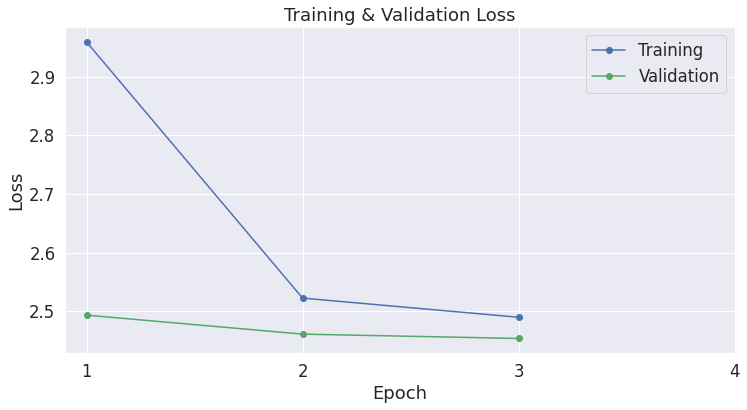

In [20]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [22]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_gpt_234/'
output_dir = os.path.join(root_folder, "./model_save_gpt_234/")

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ././model_save_gpt_234/


('././model_save_gpt_234/tokenizer_config.json',
 '././model_save_gpt_234/special_tokens_map.json',
 '././model_save_gpt_234/vocab.json',
 '././model_save_gpt_234/merges.txt',
 '././model_save_gpt_234/added_tokens.json')

In [23]:
config2 = GPT2Config.from_pretrained(output_dir)

In [24]:
model2 = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer2 = GPT2Tokenizer.from_pretrained(output_dir)

In [ ]:
!ls -l --block-size=K /content/drive/My Drive/cs182_project/./model_save/

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [25]:
model2.eval()

prompt = "<|startoftext|> OMG I absolutely loved"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)
model2 = model2.to(device)

print(generated)

sample_outputs = model2.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 43821,   314,  5543,  6151]], device='cuda:0')
0:  OMG I absolutely loved these two guys who were the best of my class. The quality of their pedicures were also fantastic. I'd give them two stars (1.5 for a great pedicure and a 4) if only because it is located in a really nice neighborhood! If you have a budget, you could get a 2-star for the quality of the pedi but I feel like you get a better deal if you're the cost of the service. The overall quality of my pedi was great.The only thing I wish I had a bit more experience with are the prices. I had to wait 2 minutes to get my pedi done, then just go out in the middle of the day and pay $12 for 2 pedi that cost over $40.


1:  OMG I absolutely loved this place! The food was amazing and the atmosphere was amazing. But I'd say the food was average at best. I ordered the "Grit" taco with avocado, chicken and lime juice which was pretty good. The price was cheap too, I got the "Iced" taco. The meat was delicious. I'd probab

These aren't bad at all!
